In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. LLeQA Dataset Exploration & Visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from datasets import load_dataset
import os
from datetime import datetime
from tqdm import tqdm

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load the dataset

In [ ]:
print("Loading LLeQA dataset...")
def load_lleqa_dataset(data_dir="/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/lleqa"):
    """Load the LLeQA dataset from JSON files."""
    questions_train = json.load(open(os.path.join(data_dir, "questions_train.json")))
    questions_dev = json.load(open(os.path.join(data_dir, "questions_dev.json")))
    questions_test = json.load(open(os.path.join(data_dir, "questions_test.json")))
    articles = json.load(open(os.path.join(data_dir, "articles.json")))

    print(f"Loaded {len(questions_train)} training questions")
    print(f"Loaded {len(questions_dev)} dev questions")
    print(f"Loaded {len(questions_test)} test questions")
    print(f"Loaded {len(articles)} legal articles")

    return {
        "train": questions_train,
        "dev": questions_dev,
        "test": questions_test,
        "articles": articles
    }

# Load dataset
data = load_lleqa_dataset()

Loading LLeQA dataset...
Loaded 1472 training questions
Loaded 201 dev questions
Loaded 195 test questions
Loaded 27942 legal articles


In [ ]:
# Convert to pandas for easier analysis
train_questions = pd.DataFrame(data['train'])
dev_questions = pd.DataFrame(data['dev'])
test_questions = pd.DataFrame(data['test'])
articles = pd.DataFrame(data['articles'])

In [ ]:
print(f"Dataset loaded successfully!")
print(f"Train: {len(train_questions)} questions")
print(f"Dev: {len(dev_questions)} questions")
print(f"Test: {len(test_questions)} questions")
print(f"Articles: {len(articles)} legal articles")

Dataset loaded successfully!
Train: 1472 questions
Dev: 201 questions
Test: 195 questions
Articles: 27942 legal articles


In [ ]:
# Combine all questions for overall analysis
all_questions = pd.concat([train_questions, dev_questions, test_questions], ignore_index=True)

## Build corpus for retrieval

In [ ]:
def build_corpus(articles):
    """Prepare corpus for retrieval experiments."""
    corpus = []
    article_ids = []

    # Article-level corpus
    for article in articles:
        article_ids.append(article['id'])
        corpus.append(article['article'])

    # Create lookup dictionaries
    article_lookup = {article['id']: article for article in articles}
    corpus_lookup = {article_id: text for article_id, text in zip(article_ids, corpus)}

    return {
        "corpus": corpus,
        "article_ids": article_ids,
        "article_lookup": article_lookup,
        "corpus_lookup": corpus_lookup
    }

# Build the corpus
corpus_data = build_corpus(data["articles"])
print(f"Built corpus with {len(corpus_data['corpus'])} documents")

Built corpus with 27942 documents


## Explore data

In [ ]:
# =============================================================================
# 1. DATASET OVERVIEW & BASIC STATISTICS
# =============================================================================

def dataset_overview():
    """Generate basic dataset statistics"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Split distribution
    split_counts = [len(train_questions), len(dev_questions), len(test_questions)]
    split_labels = ['Train', 'Dev', 'Test']

    axes[0,0].pie(split_counts, labels=split_labels, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')

    # Question length distribution
    question_lengths = [len(q.split()) for q in all_questions['question']]
    axes[0,1].hist(question_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].set_xlabel('Question Length (words)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Question Length Distribution', fontsize=14, fontweight='bold')
    axes[0,1].axvline(np.mean(question_lengths), color='red', linestyle='--',
                      label=f'Mean: {np.mean(question_lengths):.1f}')
    axes[0,1].legend()

    # Answer length distribution
    answer_lengths = [len(ans.split()) for ans in all_questions['answer']]
    axes[1,0].hist(answer_lengths, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_xlabel('Answer Length (words)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Answer Length Distribution', fontsize=14, fontweight='bold')
    axes[1,0].axvline(np.mean(answer_lengths), color='red', linestyle='--',
                      label=f'Mean: {np.mean(answer_lengths):.1f}')
    axes[1,0].legend()

    # Articles per question
    articles_per_q = [len(article_ids) for article_ids in all_questions['article_ids']]
    axes[1,1].hist(articles_per_q, bins=range(1, max(articles_per_q)+2),
                   alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].set_xlabel('Number of Relevant Articles per Question')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Articles per Question Distribution', fontsize=14, fontweight='bold')
    axes[1,1].axvline(np.mean(articles_per_q), color='red', linestyle='--',
                      label=f'Mean: {np.mean(articles_per_q):.1f}')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("DATASET SUMMARY STATISTICS")
    print("="*60)
    print(f"Total Questions: {len(all_questions):,}")
    print(f"Total Articles: {len(articles):,}")
    print(f"Average Question Length: {np.mean(question_lengths):.1f} words")
    print(f"Average Answer Length: {np.mean(answer_lengths):.1f} words")
    print(f"Average Articles per Question: {np.mean(articles_per_q):.1f}")
    print(f"Question Length Range: {min(question_lengths)} - {max(question_lengths)} words")
    print(f"Answer Length Range: {min(answer_lengths)} - {max(answer_lengths)} words")



1. Dataset Overview & Basic Statistics


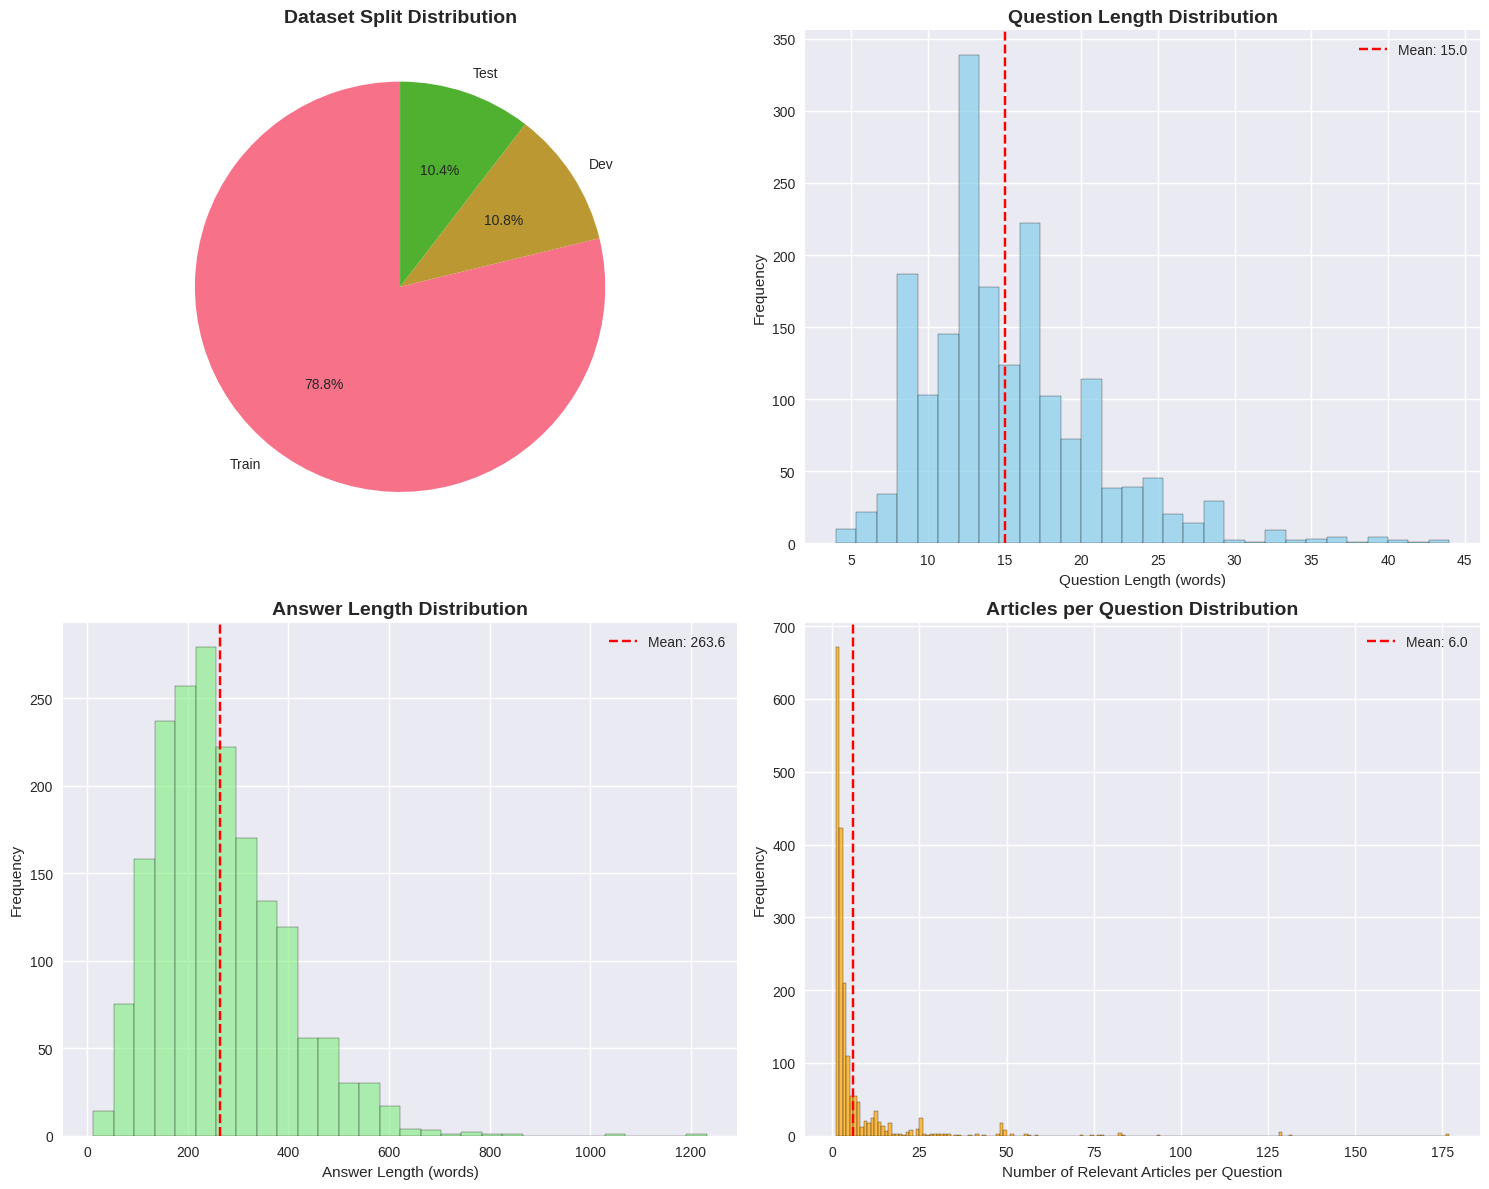


DATASET SUMMARY STATISTICS
Total Questions: 1,868
Total Articles: 27,942
Average Question Length: 15.0 words
Average Answer Length: 263.6 words
Average Articles per Question: 6.0
Question Length Range: 4 - 44 words
Answer Length Range: 12 - 1232 words


In [ ]:
# Run all analyses
print("\n1. Dataset Overview & Basic Statistics")
dataset_overview()

In [ ]:
# =============================================================================
# 2. ARTICLE ANALYSIS
# =============================================================================

def analyze_articles():
    """Analyze legal articles characteristics"""

    # Article length analysis
    article_lengths = []
    paragraph_counts = []

    for _, article in articles.iterrows():
        article_text = article['article']
        if pd.notna(article_text):
            article_lengths.append(len(article_text.split()))

        paragraphs = article['paragraphs']
        if isinstance(paragraphs, dict):
            paragraph_counts.append(len(paragraphs))
        else:
            paragraph_counts.append(0)

    # Authority distribution
    authority_counts = Counter(articles['authority'].dropna())

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Article length distribution
    axes[0,0].hist(article_lengths, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0,0].set_xlabel('Article Length (words)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Legal Article Length Distribution', fontsize=12, fontweight='bold')
    axes[0,0].axvline(np.mean(article_lengths), color='red', linestyle='--',
                      label=f'Mean: {np.mean(article_lengths):.1f}')
    axes[0,0].legend()

    # Paragraphs per article
    axes[0,1].hist(paragraph_counts, bins=range(0, max(paragraph_counts)+2),
                   alpha=0.7, color='teal', edgecolor='black')
    axes[0,1].set_xlabel('Number of Paragraphs per Article')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Paragraphs per Article Distribution', fontsize=12, fontweight='bold')

    # Authority distribution
    auth_df = pd.DataFrame(list(authority_counts.items()), columns=['Authority', 'Count'])
    axes[1,0].pie(auth_df['Count'], labels=auth_df['Authority'], autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('Legal Authority Distribution', fontsize=12, fontweight='bold')

    # Most referenced articles
    article_refs = Counter()
    for article_ids in all_questions['article_ids']:
        if isinstance(article_ids, list):
            article_refs.update(article_ids)

    top_articles = dict(article_refs.most_common(10))
    axes[1,1].bar(range(len(top_articles)), list(top_articles.values()), color='gold')
    axes[1,1].set_xlabel('Article Rank')
    axes[1,1].set_ylabel('Number of References')
    axes[1,1].set_title('Top 10 Most Referenced Articles', fontsize=12, fontweight='bold')
    axes[1,1].set_xticks(range(len(top_articles)))
    axes[1,1].set_xticklabels([f'Art.{id}' for id in top_articles.keys()], rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Average Article Length: {np.mean(article_lengths):.1f} words")
    print(f"Average Paragraphs per Article: {np.mean(paragraph_counts):.1f}")
    print(f"Most Referenced Article: Article {article_refs.most_common(1)[0][0]} ({article_refs.most_common(1)[0][1]} references)")



2. Article Analysis


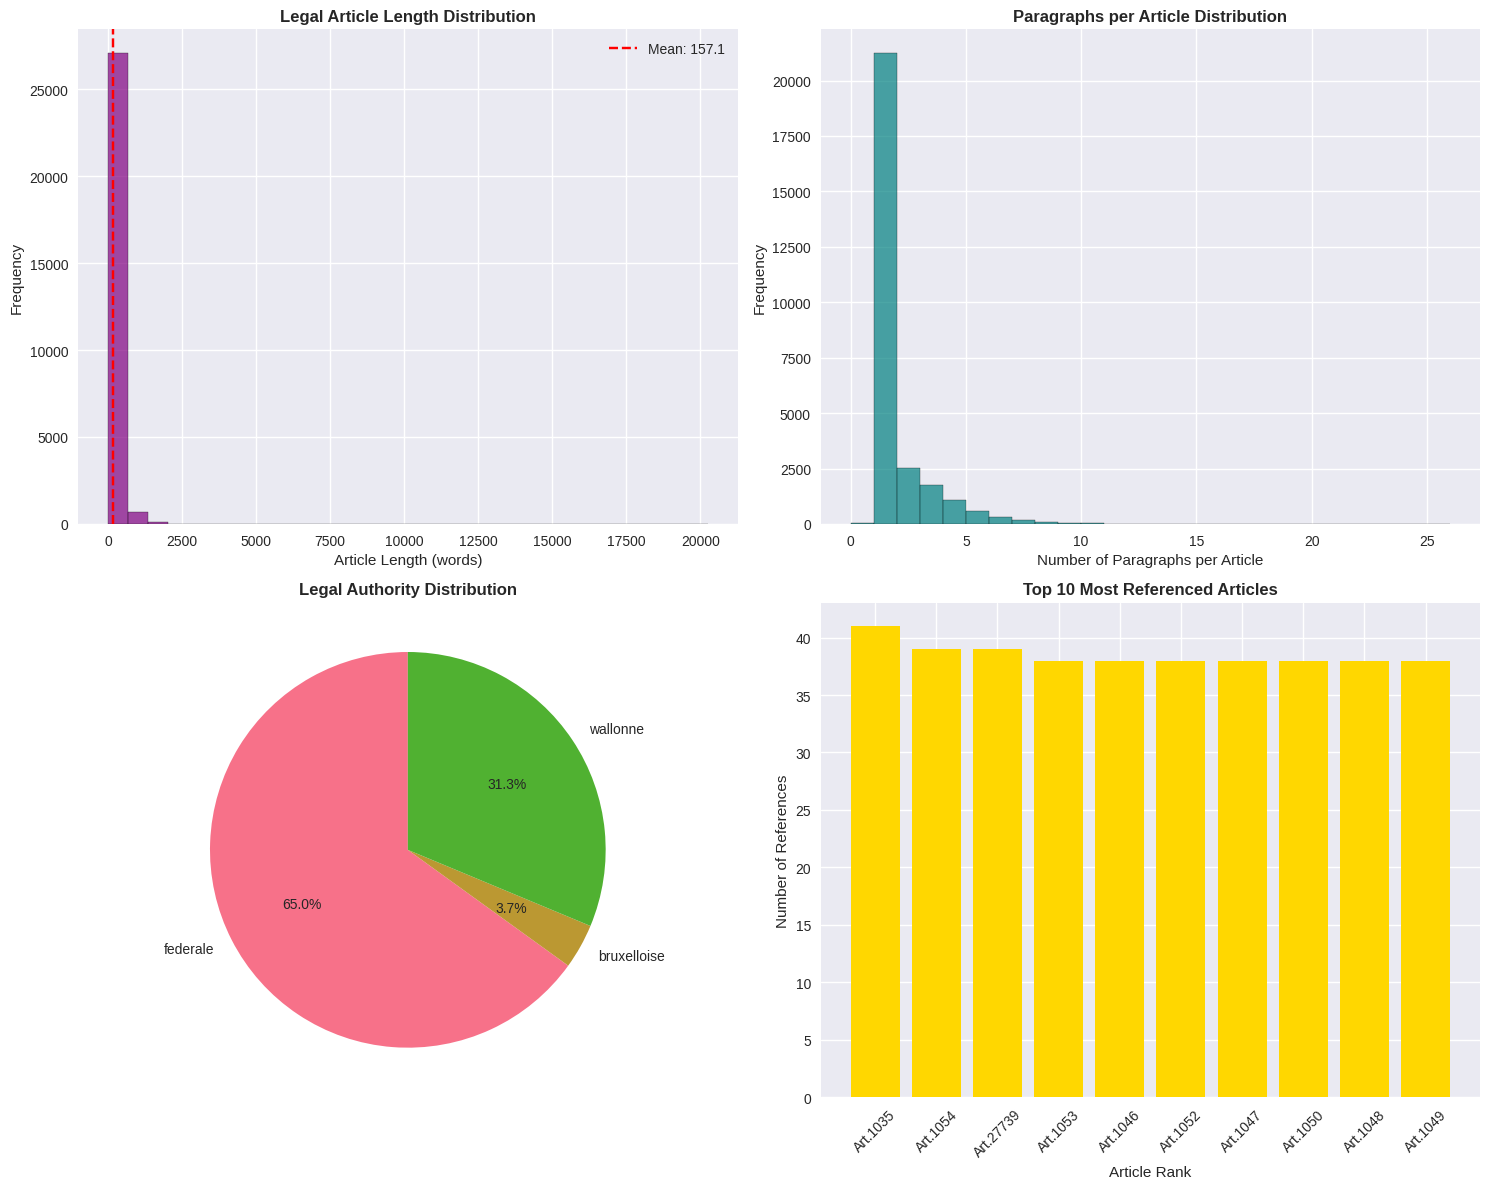

Average Article Length: 157.1 words
Average Paragraphs per Article: 1.6
Most Referenced Article: Article 1035 (41 references)


In [ ]:
print("\n2. Article Analysis")
analyze_articles()

In [ ]:
# =============================================================================
# 3. RETRIEVAL CHALLENGE ANALYSIS
# =============================================================================

def analyze_retrieval_challenges():
    """Analyze characteristics relevant for retrieval systems"""

    # Question-Answer semantic overlap
    def calculate_overlap(question, answer):
        q_words = set(question.lower().split())
        a_words = set(answer.lower().split())
        if len(q_words) == 0:
            return 0
        return len(q_words.intersection(a_words)) / len(q_words)

    overlaps = [calculate_overlap(q, a) for q, a in zip(all_questions['question'], all_questions['answer'])]

    # Question complexity indicators
    complex_indicators = []
    for question in all_questions['question']:
        indicators = {
            'has_multiple_clauses': len(re.findall(r'[.!?]', question)) > 1,
            'has_conditions': any(word in question.lower() for word in ['si', 'dans le cas', 'lorsque', 'quand']),
            'has_negation': any(word in question.lower() for word in ['ne pas', 'non', 'sans']),
            'has_comparison': any(word in question.lower() for word in ['plutôt', 'mieux', 'différence']),
        }
        complex_indicators.append(sum(indicators.values()))

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Semantic overlap distribution
    axes[0,0].hist(overlaps, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,0].set_xlabel('Question-Answer Word Overlap Ratio')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Question-Answer Semantic Overlap', fontsize=12, fontweight='bold')
    axes[0,0].axvline(np.mean(overlaps), color='red', linestyle='--',
                      label=f'Mean: {np.mean(overlaps):.3f}')
    axes[0,0].legend()

    # Question complexity
    axes[0,1].hist(complex_indicators, bins=range(6), alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_xlabel('Complexity Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Question Complexity Distribution', fontsize=12, fontweight='bold')
    axes[0,1].set_xticks(range(5))

    # Multi-article questions analysis
    multi_article_mask = [len(aids) > 1 for aids in all_questions['article_ids']]
    multi_article_ratio = sum(multi_article_mask) / len(multi_article_mask)

    labels = ['Single Article', 'Multiple Articles']
    sizes = [1-multi_article_ratio, multi_article_ratio]
    axes[1,0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange'])
    axes[1,0].set_title('Questions Requiring Multiple Articles', fontsize=12, fontweight='bold')

    # Paragraph granularity
    paragraph_counts = [len(pids) if isinstance(pids, list) else 1 for pids in all_questions['paragraph_ids']]
    axes[1,1].hist(paragraph_counts, bins=range(1, max(paragraph_counts)+2),
                   alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].set_xlabel('Number of Relevant Paragraphs')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Paragraph-level Granularity', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"Average Question-Answer Overlap: {np.mean(overlaps):.3f}")
    print(f"Questions requiring multiple articles: {multi_article_ratio:.1%}")
    print(f"Average paragraphs per question: {np.mean(paragraph_counts):.1f}")



3. Retrieval Challenge Analysis


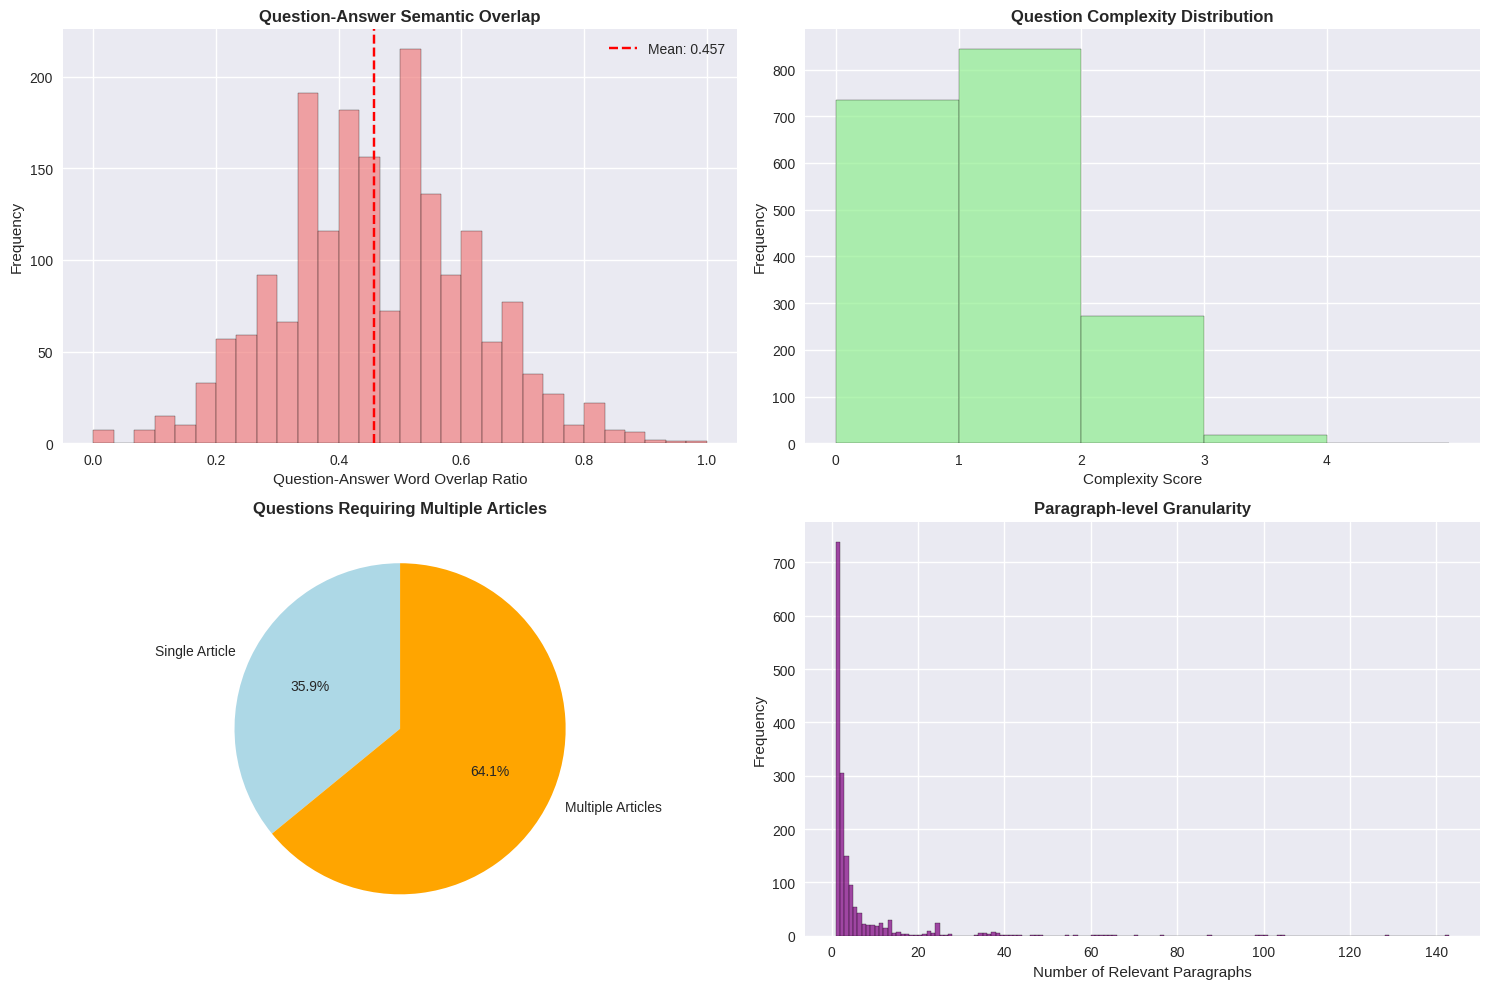

Average Question-Answer Overlap: 0.457
Questions requiring multiple articles: 64.1%
Average paragraphs per question: 4.6


In [ ]:
print("\n3. Retrieval Challenge Analysis")
analyze_retrieval_challenges()

In [ ]:
# =============================================================================
# 5. LANGUAGE & VOCABULARY ANALYSIS
# =============================================================================

def analyze_language_patterns():
    """Analyze language patterns for French legal text"""

    # Most common words in questions
    all_question_text = ' '.join(all_questions['question']).lower()
    question_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                   colormap='viridis').generate(all_question_text)

    # Most common words in answers
    all_answer_text = ' '.join(all_questions['answer']).lower()
    answer_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 colormap='plasma').generate(all_answer_text)

    fig, axes = plt.subplots(2, 1, figsize=(16, 12))

    axes[0].imshow(question_wordcloud, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Most Common Words in Legal Questions', fontsize=14, fontweight='bold')

    axes[1].imshow(answer_wordcloud, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Most Common Words in Legal Answers', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Legal terminology frequency
    legal_terms = ['droit', 'loi', 'article', 'code', 'tribunal', 'juge', 'contrat',
                   'obligation', 'responsabilité', 'procédure', 'juridique', 'légal']

    term_counts = {}
    for term in legal_terms:
        count = sum(1 for q in all_questions['question'] if term in q.lower())
        term_counts[term] = count

    plt.figure(figsize=(12, 6))
    plt.bar(term_counts.keys(), term_counts.values(), color='steelblue', alpha=0.7)
    plt.xlabel('Legal Terms')
    plt.ylabel('Frequency in Questions')
    plt.title('Legal Terminology Usage in Questions', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


5. Language & Vocabulary Analysis


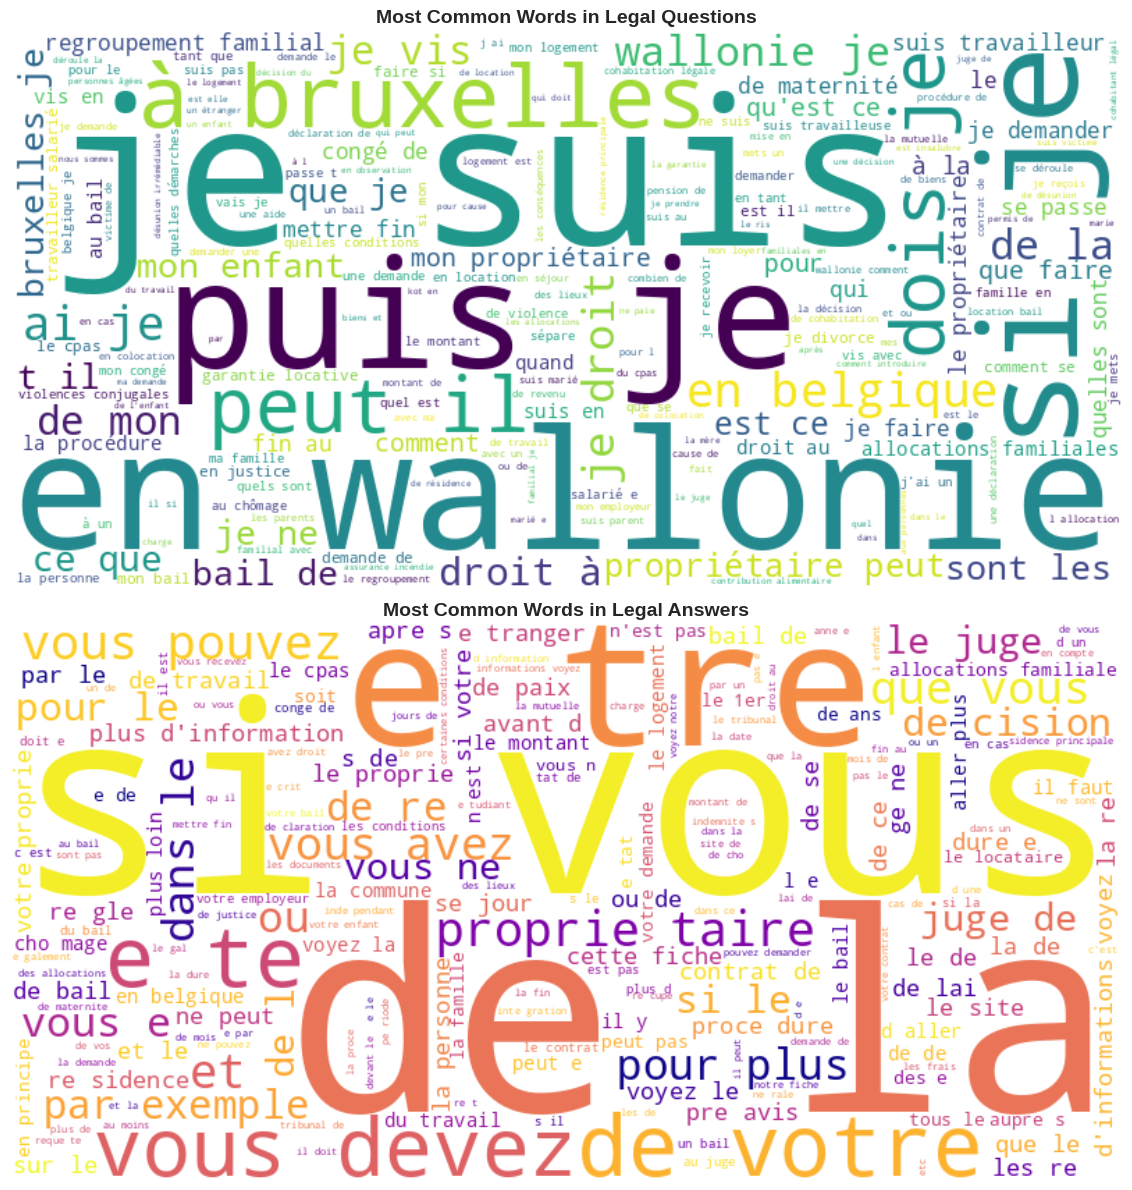

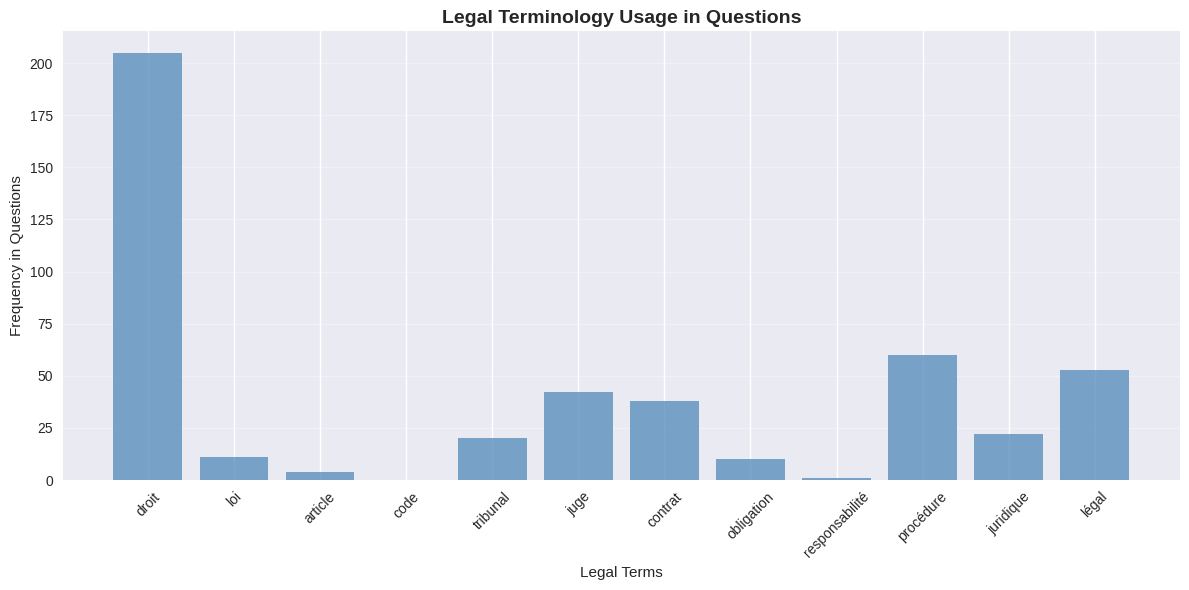

In [ ]:
print("\n5. Language & Vocabulary Analysis")
analyze_language_patterns()

In [ ]:
# =============================================================================
# 6. RETRIEVAL DIFFICULTY ASSESSMENT
# =============================================================================

def assessment_retrieval_difficulty():
    """Assess potential retrieval difficulties"""

    # Create difficulty categories
    difficulties = []
    for _, row in all_questions.iterrows():
        score = 0

        # Long questions are harder
        if len(row['question'].split()) > 20:
            score += 1

        # Multiple articles needed
        if len(row['article_ids']) > 1:
            score += 1

        # Complex topics (family law, contracts tend to be complex)
        complex_topics = ['Famille', 'Contrat', 'Responsabilité', 'Procédure']
        if any(topic in str(row['topics']) for topic in complex_topics):
            score += 1

        # Abstract questions (contain "comment", "pourquoi", "dans quels cas")
        abstract_words = ['comment', 'pourquoi', 'dans quels cas', 'quelle est la différence']
        if any(word in row['question'].lower() for word in abstract_words):
            score += 1

        difficulties.append(score)

    # Visualize difficulty distribution
    plt.figure(figsize=(10, 6))
    plt.hist(difficulties, bins=range(6), alpha=0.7, color='coral', edgecolor='black')
    plt.xlabel('Difficulty Score (0-4)')
    plt.ylabel('Number of Questions')
    plt.title('Estimated Retrieval Difficulty Distribution', fontsize=14, fontweight='bold')
    plt.xticks(range(5))
    plt.grid(axis='y', alpha=0.3)

    # Add statistics
    easy_questions = sum(1 for d in difficulties if d <= 1)
    hard_questions = sum(1 for d in difficulties if d >= 3)

    plt.text(0.7, max(Counter(difficulties).values()) * 0.8,
             f'Easy (≤1): {easy_questions} ({easy_questions/len(difficulties):.1%})\n'
             f'Hard (≥3): {hard_questions} ({hard_questions/len(difficulties):.1%})',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    plt.tight_layout()
    plt.show()

    return difficulties


6. Retrieval Difficulty Assessment


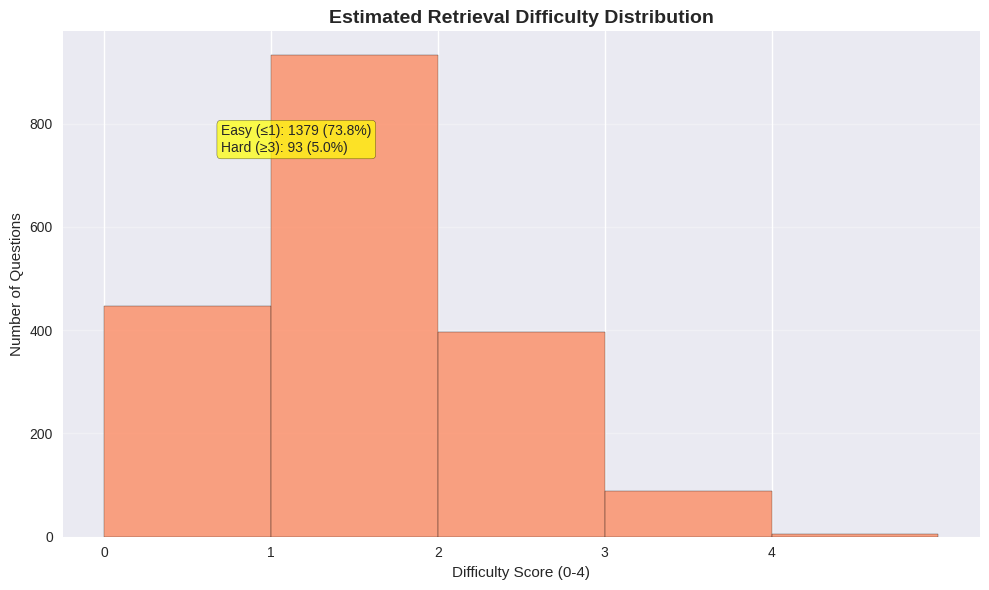

In [ ]:
print("\n6. Retrieval Difficulty Assessment")
difficulties = assessment_retrieval_difficulty()

# 2. Baseline retrieval methods

## Sparse Retrieval

In [ ]:
!pip install rank_bm25 scikit-learn

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi, BM25Plus
import pickle
import time
import os

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Text preprocessing for French text
def preprocess_text(text, language='french'):
    """Preprocess text for retrieval."""
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text, language=language)

    # Remove stopwords and punctuation
    french_stopwords = set(stopwords.words(language))
    tokens = [token for token in tokens if token.isalnum() and token not in french_stopwords]

    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### TF-IDF Retrieval

In [ ]:
class TFIDFRetriever:
    """TF-IDF based retrieval model."""
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = None
        self.corpus_ids = None

    def fit(self, corpus, corpus_ids):
        """Build the TF-IDF index."""
        self.tfidf_matrix = self.vectorizer.fit_transform(corpus)
        self.corpus_ids = corpus_ids

    def retrieve(self, query, top_k=5):
        """Retrieve top-k relevant documents."""
        query_vector = self.vectorizer.transform([query])
        scores = (query_vector @ self.tfidf_matrix.T).toarray()[0]
        top_indices = np.argsort(scores)[::-1][:top_k]

        results = [(self.corpus_ids[idx], scores[idx]) for idx in top_indices]
        return results

    def save(self, path):
        """Save the model to disk."""
        with open(path, 'wb') as f:
            pickle.dump({
                'vectorizer': self.vectorizer,
                'tfidf_matrix': self.tfidf_matrix,
                'corpus_ids': self.corpus_ids
            }, f)

    @classmethod
    def load(cls, path):
        """Load the model from disk."""
        with open(path, 'rb') as f:
            data = pickle.load(f)
            model = cls()
            model.vectorizer = data['vectorizer']
            model.tfidf_matrix = data['tfidf_matrix']
            model.corpus_ids = data['corpus_ids']
            return model

### BM25 Retrievals

In [ ]:
class BM25Retriever:
    """BM25 based retrieval model."""
    def __init__(self, variant='okapi'):
        self.variant = variant
        self.bm25 = None
        self.tokenized_corpus = None
        self.corpus_ids = None

    def fit(self, corpus, corpus_ids):
        """Build the BM25 index."""
        self.tokenized_corpus = [preprocess_text(doc) for doc in corpus]

        if self.variant == 'plus':
            self.bm25 = BM25Plus(self.tokenized_corpus)
        else:
            self.bm25 = BM25Okapi(self.tokenized_corpus)

        self.corpus_ids = corpus_ids

    def retrieve(self, query, top_k=5):
        """Retrieve top-k relevant documents."""
        query_tokens = preprocess_text(query)
        scores = self.bm25.get_scores(query_tokens)
        top_indices = np.argsort(scores)[::-1][:top_k]

        results = [(self.corpus_ids[idx], scores[idx]) for idx in top_indices]
        return results

    def save(self, path):
        """Save the model to disk."""
        with open(path, 'wb') as f:
            pickle.dump({
                'variant': self.variant,
                'bm25': self.bm25,
                'corpus_ids': self.corpus_ids
            }, f)

    @classmethod
    def load(cls, path):
        """Load the model from disk."""
        with open(path, 'rb') as f:
            data = pickle.load(f)
            model = cls(variant=data['variant'])
            model.bm25 = data['bm25']
            model.corpus_ids = data['corpus_ids']
            return model

### Fit the sparse methods

In [ ]:
def train_sparse_models(corpus_data, output_dir='/content/drive/MyDrive/legal-rag-assistant/Notebooks/models/sparse', load_if_exists=True):
    """Train and save sparse retrieval models."""
    os.makedirs(output_dir, exist_ok=True)

    corpus = corpus_data['corpus']
    article_ids = corpus_data['article_ids']

    sparse_models = {}

    # TF-IDF
    tfidf_path = f"{output_dir}/tfidf_model.pkl"
    if load_if_exists and os.path.exists(tfidf_path):
        print("Loading existing TF-IDF model...")
        sparse_models['tfidf'] = TFIDFRetriever.load(tfidf_path)
    else:
        print("Training new TF-IDF model...")
        tfidf_model = TFIDFRetriever()
        tfidf_model.fit(corpus, article_ids)
        tfidf_model.save(tfidf_path)
        sparse_models['tfidf'] = tfidf_model

    # BM25 Okapi
    bm25_okapi_path = f"{output_dir}/bm25_okapi.pkl"
    if load_if_exists and os.path.exists(bm25_okapi_path):
        print("Loading existing BM25-Okapi model...")
        sparse_models['bm25_okapi'] = BM25Retriever.load(bm25_okapi_path)
    else:
        print("Training new BM25-Okapi model...")
        bm25_okapi = BM25Retriever(variant='okapi')
        bm25_okapi.fit(corpus, article_ids)
        bm25_okapi.save(bm25_okapi_path)
        sparse_models['bm25_okapi'] = bm25_okapi

    # BM25 Plus
    bm25_plus_path = f"{output_dir}/bm25_plus.pkl"
    if load_if_exists and os.path.exists(bm25_plus_path):
        print("Loading existing BM25-Plus model...")
        sparse_models['bm25_plus'] = BM25Retriever.load(bm25_plus_path)
    else:
        print("Training new BM25-Plus model...")
        bm25_plus = BM25Retriever(variant='plus')
        bm25_plus.fit(corpus, article_ids)
        bm25_plus.save(bm25_plus_path)
        sparse_models['bm25_plus'] = bm25_plus

    return sparse_models

# Get sparse models - add load_if_exists parameter here
sparse_models = train_sparse_models(corpus_data, load_if_exists=True)
print("Sparse models are Ready")

Loading existing TF-IDF model...
Loading existing BM25-Okapi model...
Loading existing BM25-Plus model...
Sparse models are Ready


In [ ]:
# Test BM25 Okapi on a sample query from the test set
sample_query = test_questions.iloc[0]
query_text = sample_query['question']
actual_relevant_article_ids = sample_query['article_ids']

print(f"Sample Query: {query_text}")
print(f"Actual Relevant Article IDs: {actual_relevant_article_ids}")

# Retrieve top-k using BM25 Okapi
k = 5  # Define top k
retrieved_results = sparse_models['bm25_okapi'].retrieve(query_text, top_k=k)

print(f"\nTop {k} retrieved articles by BM25 Okapi:")
for article_id, score in retrieved_results:
    print(f"- Article ID: {article_id}, Score: {score:.4f}")

# Display the actual relevant articles from the corpus lookup
print("\nActual Relevant Article Contents:")
for article_id in actual_relevant_article_ids:
    if article_id in corpus_data['corpus_lookup']:
        print(f"\n--- Article {article_id} ---")
        print(corpus_data['corpus_lookup'][article_id][:500] + "...") # Print first 500 chars
    else:
        print(f"\n--- Article {article_id} not found in corpus lookup ---")

Sample Query: Puis-je introduire un recours en cas d'avis négatif concernant ma demande de nationalité ?
Actual Relevant Article IDs: [9325]

Top 5 retrieved articles by BM25 Okapi:
- Article ID: 9325, Score: 17.3232
- Article ID: 9334, Score: 17.2841
- Article ID: 9322, Score: 16.4196
- Article ID: 7423, Score: 15.1192
- Article ID: 8938, Score: 15.0358

Actual Relevant Article Contents:

--- Article 9325 ---
§ 1er. L'étranger fait la déclaration devant l'officier de l'état civil de sa résidence principale.Par dérogation à ce qui précède, les procédures visées aux articles 17 et 24, alinéa 3, peuvent être introduites devant le chef d'un poste consulaire de carrière belge qui exerce, dans ce cas, les compétences dévolues à l'officier de l'état civil par l'article 15, § 2.Lorsque les procédures sont introduites, conformément à l'alinéa 2, depuis l'étranger, l'envoi recommandé, visé au paragraphe 2, ali...


## Dense retrieval with LlamaIndex

In [ ]:
# Install required packages
!pip install llama-index llama-index-embeddings-huggingface sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
import torch
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.vector_stores import SimpleVectorStore
import tempfile

class DenseRetriever:
    """Dense retrieval model using LlamaIndex."""
    def __init__(self, embed_model=None):
        self.embed_model = embed_model or HuggingFaceEmbedding(
            model_name="intfloat/multilingual-e5-large"
        )
        Settings.embed_model = self.embed_model
        self.index = None
        self.corpus_ids = None

    def fit(self, corpus, corpus_ids):
        """Build the vector index."""
        self.corpus_ids = corpus_ids

        # Create documents
        documents = []
        for i, (doc_id, text) in enumerate(zip(corpus_ids, corpus)):
            doc = Document(
                text=text,
                metadata={"id": doc_id, "index": i}
            )
            documents.append(doc)

        # Build index
        vector_store = SimpleVectorStore()
        self.index = VectorStoreIndex.from_documents(
            documents,
            vector_store=vector_store
        )

    def retrieve(self, query, top_k=5):
        """Retrieve top-k relevant documents."""
        retriever = self.index.as_retriever(similarity_top_k=top_k)
        results = retriever.retrieve(query)

        retrieved_docs = []
        for node in results:
            doc_id = node.metadata["id"]
            score = node.score if hasattr(node, "score") else 0.0
            retrieved_docs.append((doc_id, score))

        return retrieved_docs

    def save(self, path):
        """Save the index to disk."""
        self.index.storage_context.persist(persist_dir=path)

    @classmethod
    def load(cls, path, embed_model=None):
        """Load the index from disk."""
        from llama_index.core import load_index_from_storage
        from llama_index.core import StorageContext

        model = cls(embed_model=embed_model)
        storage_context = StorageContext.from_defaults(persist_dir=path)
        model.index = load_index_from_storage(storage_context)
        return model

    def score_documents(self, query, document_ids):
        """
        Score specific documents against a query.
        Much more efficient than full corpus retrieval.
        """
        if not document_ids:
            return []

        try:
            # Get query embedding
            query_embedding = self.embed_model.get_text_embedding(query)

            # Get document embeddings for specific docs only
            doc_embeddings = []
            valid_doc_ids = []

            for doc_id in document_ids:
                try:
                    # Retrieve document from index by ID
                    doc_nodes = self.index.as_retriever().retrieve(f"id:{doc_id}")
                    if doc_nodes:
                        # Get embedding for this specific document
                        doc_embedding = doc_nodes[0].embedding
                        if doc_embedding is not None:
                            doc_embeddings.append(doc_embedding)
                            valid_doc_ids.append(doc_id)
                except:
                    continue

            if not doc_embeddings:
                return [0.0] * len(document_ids)

            # Compute similarities
            similarities = []
            for doc_embedding in doc_embeddings:
                similarity = np.dot(query_embedding, doc_embedding)
                similarities.append(similarity)

            # Map back to original document order
            result_scores = []
            valid_idx = 0
            for doc_id in document_ids:
                if valid_idx < len(valid_doc_ids) and doc_id == valid_doc_ids[valid_idx]:
                    result_scores.append(similarities[valid_idx])
                    valid_idx += 1
                else:
                    result_scores.append(0.0)

            return result_scores

        except Exception as e:
            print(f"Error in document scoring: {e}")
            return [0.0] * len(document_ids)


## Fit the dense retrieval

In [ ]:
def train_dense_models(corpus_data, output_dir='/content/drive/MyDrive/legal-rag-assistant/Notebooks/models/dense', load_if_exists=True):
    """Train and save dense retrieval models."""
    os.makedirs(output_dir, exist_ok=True)

    corpus = corpus_data['corpus']
    article_ids = corpus_data['article_ids']

    dense_models = {}

    # LlamaIndex Dense Retriever with E5
    dense_path = f"{output_dir}/dense_e5"
    if load_if_exists and os.path.exists(dense_path):
        print("Loading existing dense model...")
        dense_models['dense'] = DenseRetriever.load(dense_path)
    else:
        print("Training new dense model...")
        dense_model = DenseRetriever()
        # First fit the model
        dense_model.fit(corpus, article_ids)
        # Then save it separately
        dense_model.save(dense_path)
        dense_models['dense'] = dense_model

    return dense_models

# Get dense models
dense_models = train_dense_models(corpus_data, load_if_exists=True)
print("Dense model is Ready")

Loading existing dense model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Loading llama_index.core.storage.kvstore.simple_kvstore from /content/drive/MyDrive/legal-rag-assistant/Notebooks/models/dense/dense_e5/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from /content/drive/MyDrive/legal-rag-assistant/Notebooks/models/dense/dense_e5/index_store.json.
Dense model is Ready


In [ ]:
# Select one sample query from the test data
sample_query_index = 0
sample_query_data = test_questions.iloc[sample_query_index]
sample_query = sample_query_data['question']
actual_relevant_article_ids = sample_query_data['article_ids']

print(f"Sample Query:\n{sample_query}\n")
print(f"Actual Relevant Article IDs: {actual_relevant_article_ids}\n")

# Use the dense retriever to get top k results
dense_retriever = dense_models['dense']
top_k = 10  # You can adjust this value
dense_results = dense_retriever.retrieve(sample_query, top_k=top_k)

print(f"Dense Retrieval Top {top_k} Results:")
for i, (doc_id, score) in enumerate(dense_results):
    article_title = corpus_data['article_lookup'].get(doc_id, {}).get('title', 'N/A')
    print(f"  {i+1}. Article ID: {doc_id}, Score: {score:.4f}, Title: {article_title}")

# Display the actual relevant articles
print("\nActual Relevant Articles:")
for relevant_id in actual_relevant_article_ids:
    article_info = corpus_data['article_lookup'].get(relevant_id)
    if article_info:
        print(f"  - Article ID: {relevant_id}, Title: {article_info.get('title', 'N/A')}")
    else:
        print(f"  - Article ID: {relevant_id} (Information not found in lookup)")



Sample Query:
Puis-je introduire un recours en cas d'avis négatif concernant ma demande de nationalité ?

Actual Relevant Article IDs: [9325]

Dense Retrieval Top 10 Results:
  1. Article ID: 24966, Score: 0.8616, Title: N/A
  2. Article ID: 14399, Score: 0.8608, Title: N/A
  3. Article ID: 24443, Score: 0.8598, Title: N/A
  4. Article ID: 8860, Score: 0.8574, Title: N/A
  5. Article ID: 24888, Score: 0.8562, Title: N/A
  6. Article ID: 24733, Score: 0.8560, Title: N/A
  7. Article ID: 21039, Score: 0.8544, Title: N/A
  8. Article ID: 24544, Score: 0.8542, Title: N/A
  9. Article ID: 9334, Score: 0.8538, Title: N/A
  10. Article ID: 21049, Score: 0.8537, Title: N/A

Actual Relevant Articles:
  - Article ID: 9325, Title: N/A


# 3. Evaluation Metrics Implementation

In [ ]:
import numpy as np
from typing import List, Set, Union
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def calculate_precision_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 5) -> float:
    """Calculate precision at k."""
    if not relevant_ids or k <= 0:
        return 0.0

    retrieved = retrieved_ids[:k]
    relevant_retrieved = [doc_id in relevant_ids for doc_id in retrieved]
    return sum(relevant_retrieved) / len(retrieved) if retrieved else 0.0

def calculate_recall_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 5) -> float:
    """Calculate recall at k."""
    if not relevant_ids or k <= 0:
        return 0.0

    retrieved = retrieved_ids[:k]
    relevant_retrieved = sum(1 for doc_id in retrieved if doc_id in relevant_ids)
    return relevant_retrieved / len(relevant_ids)

def calculate_mrr(retrieved_ids: List[int], relevant_ids: List[int]) -> float:
    """Calculate Mean Reciprocal Rank."""
    if not relevant_ids:
        return 0.0

    for i, doc_id in enumerate(retrieved_ids):
        if doc_id in relevant_ids:
            return 1.0 / (i + 1)
    return 0.0

def calculate_ndcg(retrieved_ids: List[int], relevant_ids: List[int], k: int = 5) -> float:
    """Calculate NDCG at k."""
    if not relevant_ids or k <= 0:
        return 0.0

    # Create relevance array (1 if relevant, 0 otherwise)
    retrieved = retrieved_ids[:k]
    relevance = [1 if doc_id in relevant_ids else 0 for doc_id in retrieved]

    # Calculate DCG
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))

    # Calculate ideal DCG (perfect ranking of relevant docs)
    ideal_relevance = [1] * min(len(relevant_ids), k)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))

    return dcg / idcg if idcg > 0 else 0.0

def calculate_f1_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 5) -> float:
    """Calculate F1@K score."""
    if not relevant_ids or k <= 0:
        return 0.0

    # Calculate precision@k
    retrieved_k = retrieved_ids[:k]
    relevant_retrieved = sum(1 for doc_id in retrieved_k if doc_id in relevant_ids)
    precision_k = relevant_retrieved / len(retrieved_k) if retrieved_k else 0.0

    # Calculate recall@k
    recall_k = relevant_retrieved / len(relevant_ids)

    # Calculate F1@k (harmonic mean)
    if precision_k + recall_k == 0:
        return 0.0

    f1_k = 2 * (precision_k * recall_k) / (precision_k + recall_k)
    return f1_k

def calculate_map(retrieved_ids: List[int], relevant_ids: List[int]) -> float:
    """Calculate Mean Average Precision (MAP)."""
    if not relevant_ids:
        return 0.0

    relevant_set = set(relevant_ids)
    precision_values = []
    relevant_found = 0

    for i, doc_id in enumerate(retrieved_ids):
        if doc_id in relevant_set:
            relevant_found += 1
            precision_at_i = relevant_found / (i + 1)
            precision_values.append(precision_at_i)

    if not precision_values:
        return 0.0

    # Average the precision values
    return sum(precision_values) / len(relevant_ids)

def calculate_hit_rate_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 5) -> float:
    """Calculate Hit Rate@K."""
    if not relevant_ids or k <= 0:
        return 0.0

    retrieved_k = retrieved_ids[:k]
    relevant_set = set(relevant_ids)

    # Check if any retrieved document is relevant
    for doc_id in retrieved_k:
        if doc_id in relevant_set:
            return 1.0
    return 0.0

# 4. Evaluation Function

In [ ]:
def evaluate_model(model, questions, article_lookup, top_k=5):
    """Enhanced evaluation function with proper error handling for hybrid models."""
    results = {
        "precision@1": [],
        "precision@5": [],
        "recall@5": [],
        "f1@5": [],
        "mrr": [],
        "ndcg@5": [],
        "map": [],
        "hit_rate@5": [],
        "time": []
    }

    model_name = getattr(model, 'name', model.__class__.__name__)

    for question in tqdm(questions, desc=f"Evaluating {model_name}", leave=False):
        query = question["question"]
        relevant_ids = question["article_ids"]

        # Enhanced timing with error handling
        start_time = time.time()
        try:
            retrieved = model.retrieve(query, top_k=top_k)

            # Validate retrieved results
            if not isinstance(retrieved, list):
                print(f"Warning: {model_name} returned non-list result")
                retrieved = []

            # Ensure all results are valid tuples
            valid_retrieved = []
            for item in retrieved:
                if isinstance(item, tuple) and len(item) >= 2:
                    doc_id, score = item[0], item[1]
                    # Check for valid score
                    if isinstance(score, (int, float)) and not (np.isnan(score) or np.isinf(score)):
                        valid_retrieved.append((doc_id, score))
                    else:
                        valid_retrieved.append((doc_id, 0.0))  # Replace invalid scores
                else:
                    print(f"Warning: Invalid result format: {item}")

            retrieved = valid_retrieved

        except Exception as e:
            print(f"Error in {model_name}: {str(e)}")
            retrieved = []

        end_time = time.time()
        retrieval_time = end_time - start_time

        # Validate timing
        if np.isnan(retrieval_time) or np.isinf(retrieval_time) or retrieval_time < 0:
            retrieval_time = 0.001  # Small positive fallback

        # Extract document IDs for evaluation
        retrieved_ids = [doc_id for doc_id, _ in retrieved]

        # Calculate metrics with error handling
        try:
            results["precision@1"].append(calculate_precision_at_k(retrieved_ids, relevant_ids, k=1))
            results["precision@5"].append(calculate_precision_at_k(retrieved_ids, relevant_ids, k=5))
            results["recall@5"].append(calculate_recall_at_k(retrieved_ids, relevant_ids, k=5))
            results["f1@5"].append(calculate_f1_at_k(retrieved_ids, relevant_ids, k=5))
            results["mrr"].append(calculate_mrr(retrieved_ids, relevant_ids))
            results["ndcg@5"].append(calculate_ndcg(retrieved_ids, relevant_ids, k=5))
            results["map"].append(calculate_map(retrieved_ids, relevant_ids))
            results["hit_rate@5"].append(calculate_hit_rate_at_k(retrieved_ids, relevant_ids, k=5))
            results["time"].append(retrieval_time)
        except Exception as e:
            print(f"Error calculating metrics for {model_name}: {str(e)}")
            # Add zero values for failed calculations
            for metric in ["precision@1", "precision@5", "recall@5", "f1@5", "mrr", "ndcg@5", "map", "hit_rate@5"]:
                results[metric].append(0.0)
            results["time"].append(retrieval_time)

    # Calculate averages with NaN protection
    avg_results = {}
    for metric, values in results.items():
        clean_values = [v for v in values if np.isfinite(v)]
        avg_results[metric] = np.mean(clean_values) if clean_values else 0.0

    return avg_results

In [ ]:
def create_performance_visualization(results_df, output_dir, timestamp):
    """Create improved performance visualizations with better colors and readability."""

    # Define core metrics for visualization
    core_metrics = ["precision@1", "precision@5", "recall@5", "f1@5", "mrr"]
    advanced_metrics = ["ndcg@5", "map", "hit_rate@5"]

    # Define a distinct color palette
    colors = ['#2E86C1', '#28B463', '#F39C12', '#E74C3C', '#8E44AD', '#17A2B8', '#FFC107', '#6C757D']

    # 1. Core Metrics Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Core metrics bar plot
    x = np.arange(len(results_df))
    width = 0.15

    for i, metric in enumerate(core_metrics):
        offset = width * (i - len(core_metrics)/2)
        bars = ax1.bar(x + offset, results_df[metric], width,
                      label=metric.upper(), color=colors[i], alpha=0.8)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    ax1.set_title('Core Retrieval Metrics', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(results_df["model"], rotation=45, ha='right', fontsize=10)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Advanced metrics bar plot
    for i, metric in enumerate(advanced_metrics):
        offset = width * (i - len(advanced_metrics)/2)
        bars = ax2.bar(x + offset, results_df[metric], width,
                      label=metric.upper(), color=colors[i+5], alpha=0.8)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax2.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    ax2.set_title('Advanced Retrieval Metrics', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results_df["model"], rotation=45, ha='right', fontsize=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    metrics_plot_path = f"{output_dir}/retrieval_performance.png"
    plt.savefig(metrics_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Performance plot saved to {metrics_plot_path}")

In [ ]:
def create_time_visualization(results_df, output_dir, timestamp):
    """Create improved time visualization."""
    plt.figure(figsize=(12, 8))

    # Create horizontal bar chart for better readability
    bars = plt.barh(range(len(results_df)), results_df['retrieve_time_ms'],
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(results_df['retrieve_time_ms']) * 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{width:.2f} ms',
                ha='left', va='center', fontweight='bold', fontsize=11)

    plt.title("Retrieval Time Comparison", fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Average Retrieval Time (milliseconds)", fontsize=14, fontweight='bold')
    plt.ylabel("Retrieval Models", fontsize=14, fontweight='bold')
    plt.yticks(range(len(results_df)), results_df["model"], fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    # Add background color
    plt.gca().set_facecolor('#f8f9fa')

    plt.tight_layout()
    time_plot_path = f"{output_dir}/retrieval_time.png"
    plt.savefig(time_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Time comparison plot saved to {time_plot_path}")

In [ ]:
def create_insights_summary(results_df):
    """Create readable insights summary."""
    print("\n" + "="*80)
    print("🔍 RETRIEVAL PERFORMANCE INSIGHTS")
    print("="*80)

    # Best performing models per metric
    metrics = ["precision@1", "precision@5", "recall@5", "f1@5", "mrr", "ndcg@5", "map", "hit_rate@5"]

    print("\n📊 BEST PERFORMING MODELS BY METRIC:")
    print("-" * 50)
    for metric in metrics:
        best_idx = results_df[metric].idxmax()
        best_model = results_df.loc[best_idx, "model"]
        best_score = results_df.loc[best_idx, metric]
        print(f"• {metric.upper():<15}: {best_model:<20} ({best_score:.3f})")

    # Speed analysis
    print(f"\n⚡ SPEED ANALYSIS:")
    print("-" * 30)
    fastest_idx = results_df['retrieve_time_ms'].idxmin()
    slowest_idx = results_df['retrieve_time_ms'].idxmax()

    fastest_model = results_df.loc[fastest_idx, "model"]
    fastest_time = results_df.loc[fastest_idx, "retrieve_time_ms"]

    slowest_model = results_df.loc[slowest_idx, "model"]
    slowest_time = results_df.loc[slowest_idx, "retrieve_time_ms"]

    print(f"• Fastest Model: {fastest_model} ({fastest_time:.2f} ms)")
    print(f"• Slowest Model: {slowest_model} ({slowest_time:.2f} ms)")
    print(f"• Speed Difference: {((slowest_time - fastest_time) / fastest_time * 100):.1f}% slower")

    # Overall ranking
    print(f"\n🏆 OVERALL RANKING (by average normalized score):")
    print("-" * 55)

    # Normalize scores for fair comparison
    normalized_df = results_df.copy()
    for metric in metrics:
        max_val = normalized_df[metric].max()
        min_val = normalized_df[metric].min()
        if max_val > min_val:
            normalized_df[f"{metric}_norm"] = (normalized_df[metric] - min_val) / (max_val - min_val)
        else:
            normalized_df[f"{metric}_norm"] = 1.0

    # Calculate average normalized score
    norm_columns = [f"{metric}_norm" for metric in metrics]
    normalized_df['avg_score'] = normalized_df[norm_columns].mean(axis=1)
    normalized_df = normalized_df.sort_values('avg_score', ascending=False)

    for i, (_, row) in enumerate(normalized_df.iterrows()):
        medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
        print(f"{medal} {row['model']:<20} (Score: {row['avg_score']:.3f})")

    print("\n" + "="*80)

    return normalized_df

In [ ]:
def create_summary_table(results_df, output_dir, timestamp):
    """Create a clean summary table."""
    # Select key metrics for display
    display_metrics = ["precision@1", "precision@5", "recall@5", "f1@5", "mrr", "retrieve_time_ms"]
    display_df = results_df[["model"] + display_metrics].copy()

    # Round values for better display
    for col in display_metrics:
        if col == "retrieve_time_ms":
            display_df[col] = display_df[col].round(2)
        else:
            display_df[col] = display_df[col].round(3)

    # Rename columns for better readability
    display_df.columns = ["Model", "P@1", "P@5", "R@5", "F1@5", "MRR", "Time (ms)"]

    # Create table visualization
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('tight')
    ax.axis('off')

    # Create table with alternating row colors
    table = ax.table(cellText=display_df.values,
                    colLabels=display_df.columns,
                    cellLoc='center',
                    loc='center')

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Color header
    for i in range(len(display_df.columns)):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(display_df) + 1):
        for j in range(len(display_df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
            else:
                table[(i, j)].set_facecolor('#ffffff')

    plt.title("Retrieval Models Performance Summary", fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()

    summary_path = f"{output_dir}/retrieval_summary.png"
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Summary table saved to {summary_path}")

# 5. Baseline Retrievals Evaluation and comparing

In [ ]:
def evaluate_baselines(sparse_models, dense_models, questions, output_dir="results"):
    """Evaluate baseline sparse and dense models with improved visualizations."""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Prepare results list
    results = []

    # Setup overall progress bar
    models = list(sparse_models.items()) + list(dense_models.items())
    overall_pbar = tqdm(total=len(models), desc="Overall evaluation progress")

    # Evaluate TF-IDF
    print("Evaluating TF-IDF model...")
    tfidf_results = evaluate_model(sparse_models['tfidf'], questions, corpus_data['article_lookup'])
    tfidf_results["model"] = "TF-IDF"
    tfidf_results["retrieve_time_ms"] = tfidf_results["time"] * 1000
    results.append(tfidf_results)
    overall_pbar.update(1)

    # Evaluate BM25-Okapi
    print("Evaluating BM25-Okapi model...")
    bm25_okapi_results = evaluate_model(sparse_models['bm25_okapi'], questions, corpus_data['article_lookup'])
    bm25_okapi_results["model"] = "BM25-Okapi"
    bm25_okapi_results["retrieve_time_ms"] = bm25_okapi_results["time"] * 1000
    results.append(bm25_okapi_results)
    overall_pbar.update(1)

    # Evaluate BM25-Plus
    print("Evaluating BM25-Plus model...")
    bm25_plus_results = evaluate_model(sparse_models['bm25_plus'], questions, corpus_data['article_lookup'])
    bm25_plus_results["model"] = "BM25-Plus"
    bm25_plus_results["retrieve_time_ms"] = bm25_plus_results["time"] * 1000
    results.append(bm25_plus_results)
    overall_pbar.update(1)

    # Evaluate Dense (LlamaIndex)
    print("Evaluating Dense model...")
    dense_results = evaluate_model(dense_models['dense'], questions, corpus_data['article_lookup'])
    dense_results["model"] = "LlamaIndex Dense"
    dense_results["retrieve_time_ms"] = dense_results["time"] * 1000
    results.append(dense_results)
    overall_pbar.update(1)

    overall_pbar.close()

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    csv_path = f"{output_dir}/retrieval_evaluation.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    # Create visualizations
    create_performance_visualization(results_df, output_dir, timestamp)
    create_time_visualization(results_df, output_dir, timestamp)
    create_summary_table(results_df, output_dir, timestamp)

    # Generate insights
    insights_df = create_insights_summary(results_df)

    return results_df

Overall evaluation progress:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating TF-IDF model...



Overall evaluation progress:  25%|██▌       | 1/4 [00:05<00:16,  5.49s/it]

Evaluating BM25-Okapi model...



Overall evaluation progress:  50%|█████     | 2/4 [00:16<00:17,  8.73s/it]

Evaluating BM25-Plus model...



Overall evaluation progress:  75%|███████▌  | 3/4 [00:27<00:09,  9.88s/it]

Evaluating Dense model...



Overall evaluation progress: 100%|██████████| 4/4 [06:42<00:00, 100.73s/it]


Results saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods/retrieval_evaluation.csv


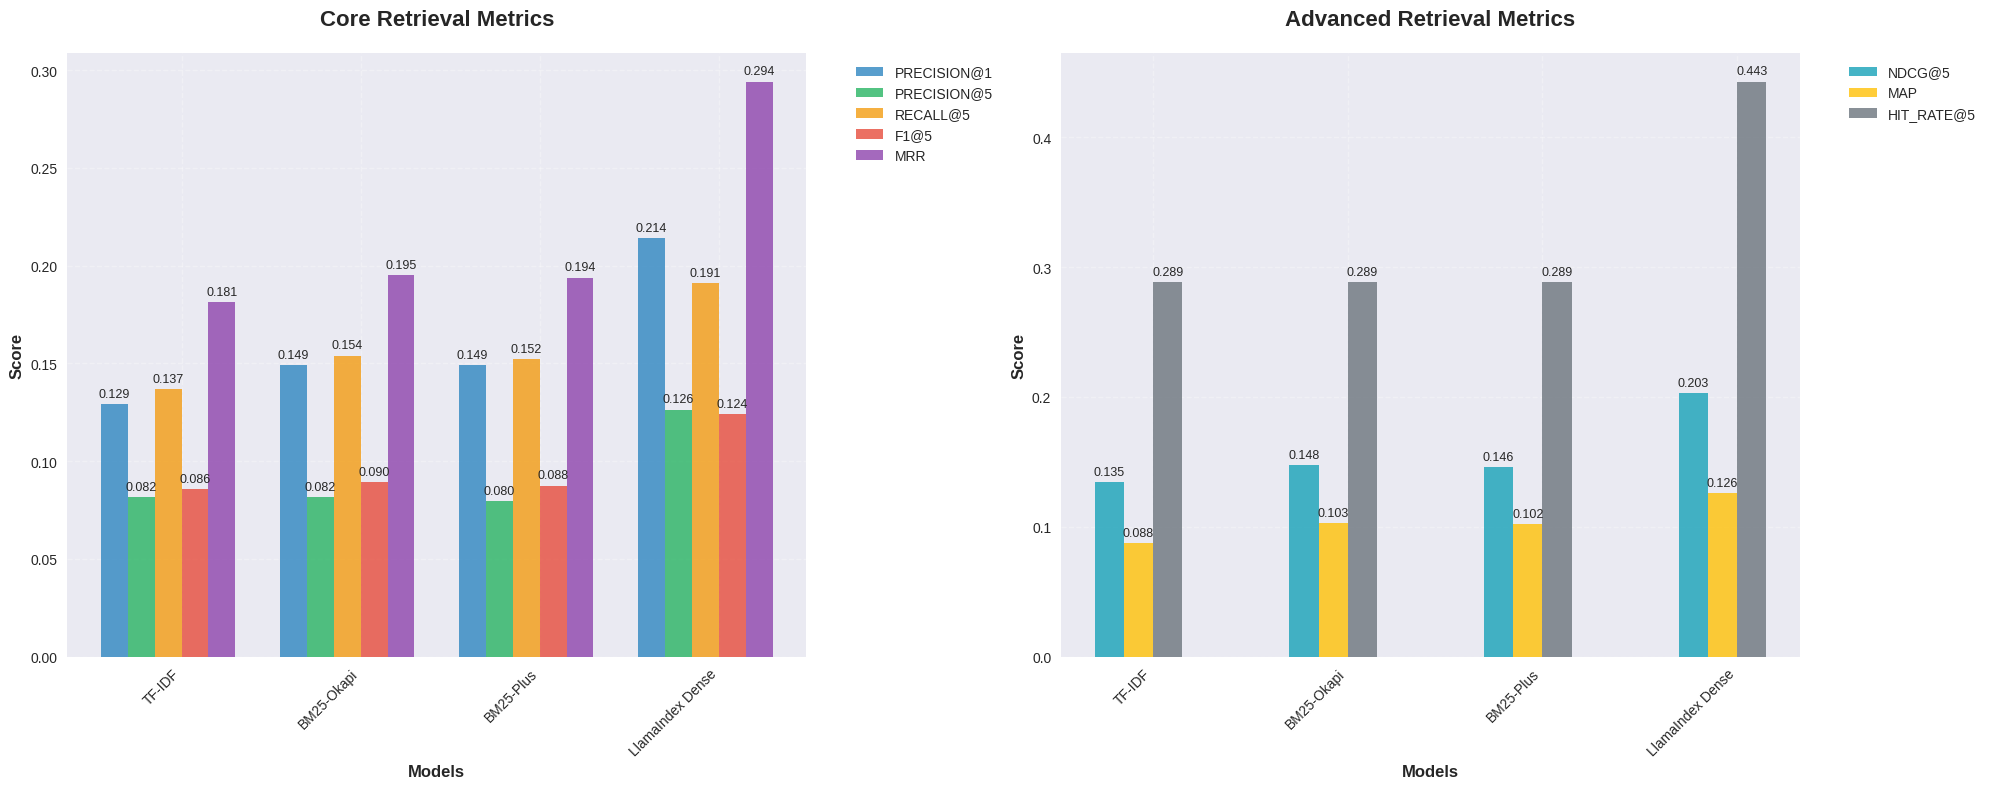

Performance plot saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods/retrieval_performance.png


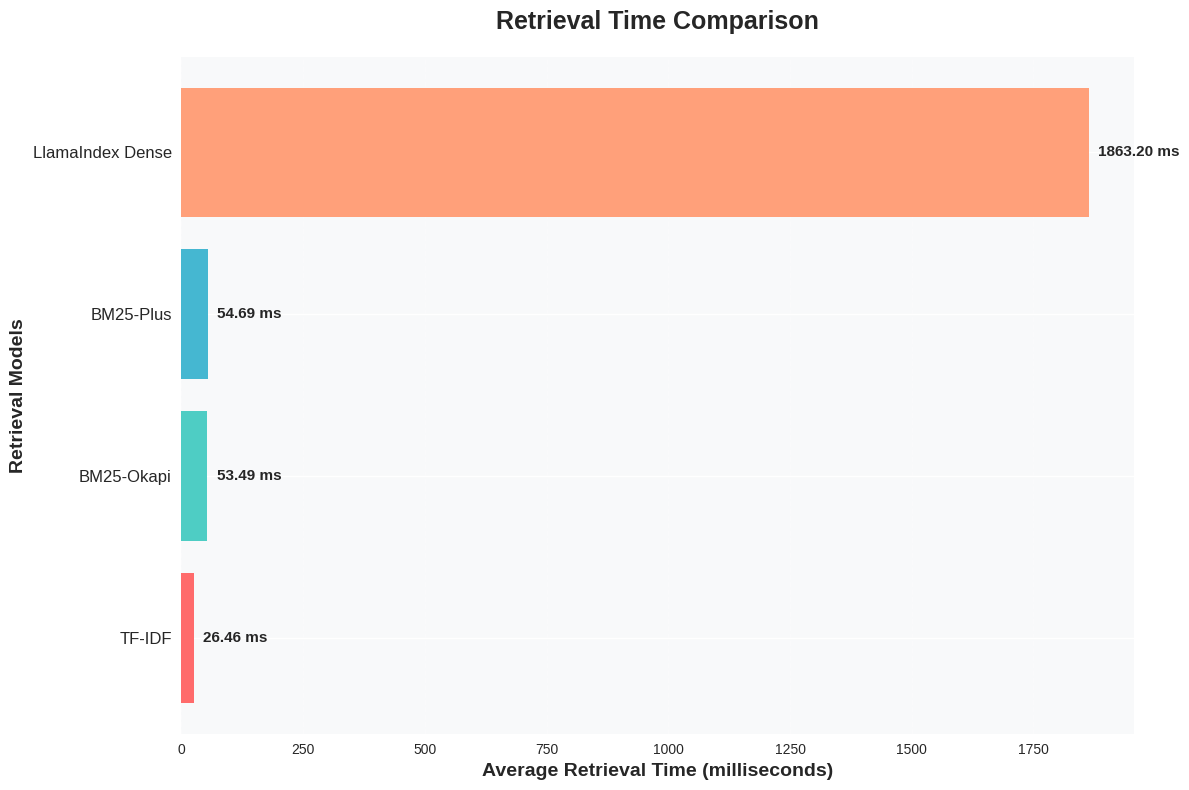

Time comparison plot saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods/retrieval_time.png


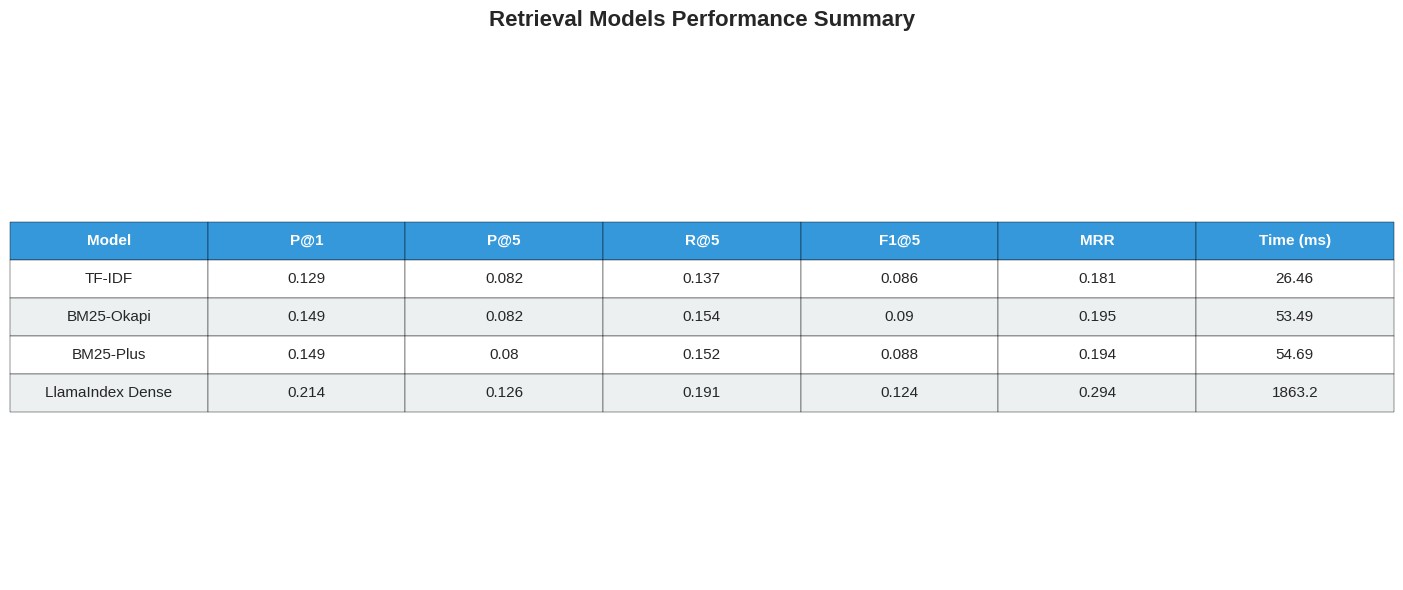

Summary table saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods/retrieval_summary.png

🔍 RETRIEVAL PERFORMANCE INSIGHTS

📊 BEST PERFORMING MODELS BY METRIC:
--------------------------------------------------
• PRECISION@1    : LlamaIndex Dense     (0.214)
• PRECISION@5    : LlamaIndex Dense     (0.126)
• RECALL@5       : LlamaIndex Dense     (0.191)
• F1@5           : LlamaIndex Dense     (0.124)
• MRR            : LlamaIndex Dense     (0.294)
• NDCG@5         : LlamaIndex Dense     (0.203)
• MAP            : LlamaIndex Dense     (0.126)
• HIT_RATE@5     : LlamaIndex Dense     (0.443)

⚡ SPEED ANALYSIS:
------------------------------
• Fastest Model: TF-IDF (26.46 ms)
• Slowest Model: LlamaIndex Dense (1863.20 ms)
• Speed Difference: 6941.6% slower

🏆 OVERALL RANKING (by average normalized score):
-------------------------------------------------------
🥇 LlamaIndex Dense     (Score: 1.000)
🥈 BM25-Okapi           (Score: 0.176)
🥉 BM25-Plus     

In [ ]:
# Create results directory
if not os.path.exists('/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods'):
    os.makedirs('/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods')

# Evaluate baseline models on dev set
baseline_results = evaluate_baselines(sparse_models, dense_models, data["dev"],
                                     output_dir="/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods")

# 6. Standart Hybrid IR Strategies

## STRATEGY 1: WEIGHTED LINEAR SCORE FUSION

**How it works:**
- Get scores from both models
- Final Score = (α × Sparse Score) + ((1-α) × Dense Score)
- α = mixing weight (0.7 means 70% sparse, 30% dense)

**Example:**
- Sparse finds Doc A with score 0.8
- Dense finds Doc A with score 0.6  
- α = 0.7
- Final: 0.7×0.8 + 0.3×0.6 = 0.56 + 0.18 = 0.74

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

class LinearScoreFusion:
    """Enhanced Linear Score Fusion with better error handling."""

    def __init__(self, sparse_model, dense_model, alpha=0.5):
        self.sparse_model = sparse_model
        self.dense_model = dense_model
        self.alpha = alpha
        self.name = f"linear_{alpha:.1f}"

    def retrieve(self, query, top_k=5):
        try:
            # Get results from both models with error handling
            sparse_results = []
            dense_results = []

            try:
                sparse_results = self.sparse_model.retrieve(query, top_k=100)
                if not isinstance(sparse_results, list):
                    sparse_results = []
            except Exception as e:
                print(f"⚠️  Sparse model error: {e}")
                sparse_results = []

            try:
                dense_results = self.dense_model.retrieve(query, top_k=100)
                if not isinstance(dense_results, list):
                    dense_results = []
            except Exception as e:
                print(f"⚠️  Dense model error: {e}")
                dense_results = []

            # Handle empty results
            if not sparse_results and not dense_results:
                return []

            # Normalize scores safely
            sparse_scores = self._normalize_scores_safe([score for _, score in sparse_results])
            dense_scores = self._normalize_scores_safe([score for _, score in dense_results])

            # Create score dictionaries
            sparse_dict = {doc_id: norm_score for (doc_id, _), norm_score in zip(sparse_results, sparse_scores)}
            dense_dict = {doc_id: norm_score for (doc_id, _), norm_score in zip(dense_results, dense_scores)}

            # Combine scores
            combined_scores = {}
            all_docs = set(sparse_dict.keys()) | set(dense_dict.keys())

            for doc_id in all_docs:
                sparse_score = sparse_dict.get(doc_id, 0.0)
                dense_score = dense_dict.get(doc_id, 0.0)
                combined_score = self.alpha * sparse_score + (1 - self.alpha) * dense_score

                # Validate combined score
                if np.isfinite(combined_score):
                    combined_scores[doc_id] = combined_score

            # Sort and return top-k
            if not combined_scores:
                return []

            sorted_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
            return sorted_results[:top_k]

        except Exception as e:
            print(f"❌ Error in LinearScoreFusion.retrieve: {e}")
            return []

    def _normalize_scores_safe(self, scores):
        """Safe score normalization with multiple fallback strategies."""
        if not scores:
            return []

        # Filter finite scores
        finite_scores = [s for s in scores if np.isfinite(s)]
        if not finite_scores:
            return [0.0] * len(scores)

        # Choose normalization method based on score characteristics
        try:
            # Try min-max first (most robust for different score ranges)
            return self._normalize_scores_minmax(scores)
        except Exception:
            try:
                # Fallback to rank-based normalization
                return self._normalize_scores_rank(scores)
            except Exception:
                # Final fallback: return uniform scores
                return [0.5] * len(scores)

    def _normalize_scores_minmax(self, scores):
        """Simple min-max normalization - often works better than z-score+sigmoid"""
        if not scores:
            return []

        finite_scores = [s for s in scores if np.isfinite(s)]
        if not finite_scores:
            return [0.0] * len(scores)

        min_score = min(finite_scores)
        max_score = max(finite_scores)

        if max_score == min_score:
            return [1.0] * len(scores)

        normalized = []
        for score in scores:
            if np.isfinite(score):
                norm_score = (score - min_score) / (max_score - min_score)
                normalized.append(norm_score)
            else:
                normalized.append(0.0)

        return normalized

    def _normalize_scores_rank(self, scores):
        """Rank-based normalization as fallback."""
        if not scores:
            return []

        # Create score-index pairs for sorting
        score_pairs = [(score, idx) for idx, score in enumerate(scores)]

        # Sort by score (descending), handling NaN/inf
        def safe_sort_key(pair):
            score, _ = pair
            if np.isfinite(score):
                return score
            else:
                return float('-inf')  # Put invalid scores at the end

        sorted_pairs = sorted(score_pairs, key=safe_sort_key, reverse=True)

        # Assign rank-based scores
        n = len(scores)
        normalized = [0.0] * n

        for rank, (_, original_idx) in enumerate(sorted_pairs):
            # Linear ranking: best=1.0, worst=1/n
            rank_score = (n - rank) / n
            normalized[original_idx] = rank_score

        return normalized

## STRATEGY 2: RECIPROCAL RANK FUSION (RRF)

**How it works:**
- Each model ranks documents 1st, 2nd, 3rd...
- Give points: 1/(k+rank) where k=60
- Add up points from all models

**Example:**
- Sparse ranks Doc A as #1 → 1/(60+1) = 0.016 points
- Dense ranks Doc A as #3 → 1/(60+3) = 0.016 points  
- Total: 0.016 + 0.016 = 0.032 points

In [ ]:
class ReciprocalRankFusion:
    """Combine rankings using Reciprocal Rank Fusion algorithm."""

    def __init__(self, sparse_model, dense_model, k=60):
        """
        Initialize with models and RRF constant.

        Args:
            sparse_model: Sparse retriever (BM25 or TF-IDF)
            dense_model: Dense retriever (embedding model)
            k: RRF constant (typically 60)
        """
        self.sparse_model = sparse_model
        self.dense_model = dense_model
        self.k = k
        self.name = f"rrf_k{k}"

    def retrieve(self, query, top_k=5):
        # Get results from both models
        sparse_results = self.sparse_model.retrieve(query, top_k=100)
        dense_results = self.dense_model.retrieve(query, top_k=100)

        # Calculate RRF scores
        rrf_scores = {}

        # Add sparse rankings
        for rank, (doc_id, _) in enumerate(sparse_results):
            rrf_scores[doc_id] = rrf_scores.get(doc_id, 0) + 1 / (self.k + rank + 1)

        # Add dense rankings
        for rank, (doc_id, _) in enumerate(dense_results):
            rrf_scores[doc_id] = rrf_scores.get(doc_id, 0) + 1 / (self.k + rank + 1)

        # Sort and return top-k
        sorted_results = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_results[:top_k]

## STRATEGY 3: TWO-STAGE CASCADE RETRIEVAL

**How it works:**
1. Stage 1: Fast sparse model finds 100 candidates
2. Stage 2: Slow dense model re-ranks those 100
3. Return top 5 from re-ranking

In [ ]:
class CascadeRetrieval:
    """True cascade with document-specific dense scoring."""

    def __init__(self, sparse_model, dense_model, corpus_data, first_stage_k=100):
        self.sparse_model = sparse_model
        self.dense_model = dense_model
        self.corpus_data = corpus_data  # Add this parameter
        self.first_stage_k = first_stage_k
        self.name = f"proper_cascade_k{first_stage_k}"

    def retrieve(self, query, top_k=5):
        try:
            # Stage 1: Fast sparse retrieval
            candidates = self._safe_retrieve(self.sparse_model, query, self.first_stage_k)

            if not candidates:
                return []

            candidate_ids = [doc_id for doc_id, _ in candidates]

            # Stage 2: Score ONLY the candidates with dense model
            dense_scores = self._score_candidates_only(query, candidate_ids)

            if not dense_scores:
                # Fallback to sparse ranking if dense scoring fails
                return candidates[:top_k]

            # Combine and re-rank by dense scores
            reranked = []
            for doc_id, dense_score in zip(candidate_ids, dense_scores):
                if dense_score is not None:
                    reranked.append((doc_id, dense_score))

            # Sort by dense scores
            reranked.sort(key=lambda x: x[1], reverse=True)
            return reranked[:top_k]

        except Exception as e:
            print(f"❌ Cascade error: {e}")
            return []

    def _score_candidates_only(self, query, candidate_ids):

        try:
            # Get more dense results to ensure good coverage
            dense_retrieve_k = min(len(candidate_ids) * 4, 800)
            dense_results = self.dense_model.retrieve(query, top_k=dense_retrieve_k)

            if not dense_results:
                return None

            # Create lookup dictionary
            dense_dict = {doc_id: score for doc_id, score in dense_results}

            # Get scores for candidates
            candidate_scores = []
            for doc_id in candidate_ids:
                score = dense_dict.get(doc_id, 0.0)  # Use 0.0 for missing candidates
                candidate_scores.append(score)

            return candidate_scores

        except Exception as e:
            print(f"⚠️  Dense scoring failed: {e}")
            return None

    def _compute_candidate_similarities(self, query, candidate_ids):
        """
        Compute similarities for specific documents using embedding model directly.
        """
        try:
            # Get query embedding
            embed_model = self.dense_model.embed_model
            query_embedding = embed_model.get_text_embedding(query)

            if query_embedding is None:
                return None

            # Get document embeddings for candidates
            candidate_scores = []

            for doc_id in candidate_ids:
                try:
                    # Get document content (you'll need to implement this)
                    doc_content = self._get_document_content(doc_id)

                    if doc_content:
                        # Get document embedding
                        doc_embedding = embed_model.get_text_embedding(doc_content)

                        if doc_embedding:
                            # Compute cosine similarity
                            similarity = np.dot(query_embedding, doc_embedding)
                            candidate_scores.append(similarity)
                        else:
                            candidate_scores.append(0.0)
                    else:
                        candidate_scores.append(0.0)

                except Exception as e:
                    print(f"⚠️  Error scoring document {doc_id}: {e}")
                    candidate_scores.append(0.0)

            return candidate_scores

        except Exception as e:
            print(f"⚠️  Error computing similarities: {e}")
            return None

    def _get_document_content(self, doc_id):
        """
        Get document content by ID using the provided corpus data.
        """
        try:
            # Use the corpus_lookup for direct access
            if self.corpus_data and 'corpus_lookup' in self.corpus_data:
                content = self.corpus_data['corpus_lookup'].get(doc_id, '')
                if content:
                    return content

            # Fallback: search in articles list
            if self.corpus_data and 'article_lookup' in self.corpus_data:
                article = self.corpus_data['article_lookup'].get(doc_id)
                if article and 'article' in article:
                    return article['article']

            # Final fallback: empty string
            return ''

        except Exception as e:
            print(f"⚠️  Error getting document content for {doc_id}: {e}")
            return ''

    def _safe_retrieve(self, model, query, top_k):
        """Safe retrieval with error handling."""
        try:
            results = model.retrieve(query, top_k=top_k)
            if isinstance(results, list) and results:
                return results
            return []
        except Exception as e:
            print(f"⚠️  Retrieval error: {e}")
            return []

## STRATEGY 4: CombMNZ FUSION

**How it works:**
- Step 1: Add scores (like linear fusion)
- Step 2: Multiply by number of models that found it
- More models finding it = bigger boost

**Example:**
- Doc A: Sparse=0.8, Dense=0.6 → Sum=1.4, Found by 2 models → Final=1.4×2=2.8
- Doc B: Sparse=0.9, Dense=0.0 → Sum=0.9, Found by 1 model → Final=0.9×1=0.9

In [ ]:
class CombMNZ:
    """Enhanced CombMNZ with better normalization and error handling."""

    def __init__(self, sparse_model, dense_model, min_presence=1, normalization='z_score'):
        self.sparse_model = sparse_model
        self.dense_model = dense_model
        self.min_presence = min_presence
        self.normalization = normalization
        self.name = f"combmnz_improved_{min_presence}_{normalization}"

    def retrieve(self, query, top_k=5):
        try:
            # Safe retrieval with error handling
            sparse_results = self._safe_retrieve(self.sparse_model, query, 100)
            dense_results = self._safe_retrieve(self.dense_model, query, 100)

            if not sparse_results and not dense_results:
                return []

            # Convert to dictionaries and normalize
            sparse_dict = self._normalize_scores(dict(sparse_results), self.normalization)
            dense_dict = self._normalize_scores(dict(dense_results), self.normalization)

            # Calculate CombMNZ scores
            combined_scores = {}
            all_docs = set(sparse_dict.keys()) | set(dense_dict.keys())

            for doc_id in all_docs:
                # Count presence
                presence = sum([
                    1 if doc_id in sparse_dict else 0,
                    1 if doc_id in dense_dict else 0
                ])

                # Skip if below minimum presence
                if presence < self.min_presence:
                    continue

                # Sum of normalized scores
                sum_score = sparse_dict.get(doc_id, 0.0) + dense_dict.get(doc_id, 0.0)

                # CombMNZ = sum * presence count
                combined_score = sum_score * presence

                # Validate score
                if np.isfinite(combined_score):
                    combined_scores[doc_id] = combined_score

            # Sort and return top-k
            if not combined_scores:
                return []

            sorted_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
            return sorted_results[:top_k]

        except Exception as e:
            print(f"❌ Error in CombMNZ.retrieve: {e}")
            return []

    def _safe_retrieve(self, model, query, top_k):
        """Safe retrieval with error handling."""
        try:
            results = model.retrieve(query, top_k=top_k)
            if not isinstance(results, list):
                return []

            # Validate results format
            valid_results = []
            for item in results:
                if isinstance(item, tuple) and len(item) >= 2:
                    doc_id, score = item[0], item[1]
                    if isinstance(score, (int, float)) and np.isfinite(score):
                        valid_results.append((doc_id, float(score)))

            return valid_results

        except Exception as e:
            print(f"⚠️  Model retrieval error: {e}")
            return []

    def _normalize_scores(self, score_dict, method='z_score'):
        """Normalize scores using specified method."""
        if not score_dict:
            return {}

        scores = list(score_dict.values())
        finite_scores = [s for s in scores if np.isfinite(s)]

        if not finite_scores:
            return {k: 0.5 for k in score_dict.keys()}

        if method == 'min_max':
            return self._min_max_normalize(score_dict, finite_scores)
        elif method == 'z_score':
            return self._z_score_normalize(score_dict, finite_scores)
        elif method == 'rank_based':
            return self._rank_based_normalize(score_dict)
        else:
            return self._z_score_normalize(score_dict, finite_scores)

    def _min_max_normalize(self, score_dict, finite_scores):
        """Min-max normalization to [0,1]."""
        min_score = min(finite_scores)
        max_score = max(finite_scores)
        score_range = max_score - min_score

        if score_range == 0:
            return {k: 1.0 for k in score_dict.keys()}

        normalized = {}
        for doc_id, score in score_dict.items():
            if np.isfinite(score):
                normalized[doc_id] = (score - min_score) / score_range
            else:
                normalized[doc_id] = 0.0

        return normalized

    def _z_score_normalize(self, score_dict, finite_scores):
        """Z-score normalization with sigmoid conversion."""
        mean_score = np.mean(finite_scores)
        std_score = np.std(finite_scores)

        if std_score == 0 or np.isclose(std_score, 0):
            return {k: 0.75 for k in score_dict.keys()}

        normalized = {}
        for doc_id, score in score_dict.items():
            if np.isfinite(score):
                z_score = (score - mean_score) / std_score
                # Convert to [0,1] using sigmoid
                sigmoid_score = 1 / (1 + np.exp(-z_score))
                normalized[doc_id] = sigmoid_score
            else:
                normalized[doc_id] = 0.5

        return normalized

    def _rank_based_normalize(self, score_dict):
        """Rank-based normalization (most robust)."""
        if not score_dict:
            return {}

        # Sort by score (descending)
        sorted_items = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)
        n = len(sorted_items)

        # Assign rank-based scores
        normalized = {}
        for rank, (doc_id, _) in enumerate(sorted_items):
            # Convert rank to score: 1.0 for rank 1, decreasing
            normalized_score = 1.0 - (rank / max(n - 1, 1))
            normalized[doc_id] = normalized_score

        return normalized

In [ ]:
# Create improved CombMNZ models
combmnz_models = {
    'combmnz_zscore': CombMNZ(
        sparse_models['bm25_plus'],
        dense_models['dense'],
        min_presence=1,
        normalization='z_score'
    ),
    'combmnz_rank': CombMNZ(
        sparse_models['bm25_plus'],
        dense_models['dense'],
        min_presence=1,
        normalization='rank_based'
    ),
    'combmnz_minmax': CombMNZ(
        sparse_models['bm25_plus'],
        dense_models['dense'],
        min_presence=1,
        normalization='min_max'  # Your original method
    )
}

### Evaluate different normalization strategies for CombMNZ

In [ ]:
# prompt: i want to evaluate and compare those combmnz models and visualise to see wich normalisation gives better result

import pandas as pd
def evaluate_normalization_strategies(combmnz_models, questions, article_lookup, output_dir="results/combmnz_eval"):
    """Evaluate different normalization strategies for CombMNZ."""
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    results = []

    overall_pbar = tqdm(total=len(combmnz_models), desc="Evaluating CombMNZ strategies")

    for name, model in combmnz_models.items():
        print(f"Evaluating {name}...")
        model_results = evaluate_model(model, questions, article_lookup)
        model_results["model"] = name
        model_results["retrieve_time_ms"] = model_results["time"] * 1000 # Convert seconds to ms
        results.append(model_results)
        overall_pbar.update(1)

    overall_pbar.close()

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    csv_path = f"{output_dir}/combmnz_normalization_evaluation.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    # Create visualizations
    create_performance_visualization(results_df, output_dir, timestamp)
    create_time_visualization(results_df, output_dir, timestamp)
    create_summary_table(results_df, output_dir, timestamp)

    # Generate insights
    insights_df = create_insights_summary(results_df)

    return results_df

# Create results directory for CombMNZ normalization comparison
combmnz_eval_dir = '/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/combmnz-normalization'
if not os.path.exists(combmnz_eval_dir):
    os.makedirs(combmnz_eval_dir)

# Evaluate the CombMNZ models with different normalizations on the dev set
combmnz_normalization_results = evaluate_normalization_strategies(
    combmnz_models,
    data["dev"],
    corpus_data['article_lookup'],
    output_dir=combmnz_eval_dir
)

print("\nCombMNZ Normalization Evaluation Complete.")
print(combmnz_normalization_results)

## STRATEGY 5 : confidence-aware score fusion

In [ ]:
import numpy as np
from typing import List, Tuple, Dict

class ConfidenceAwareFusion:
    """
    Properly implemented confidence-aware fusion.
    """

    def __init__(self, sparse_model, dense_model, base_alpha=0.5):
        self.sparse_model = sparse_model
        self.dense_model = dense_model
        self.base_alpha = base_alpha
        self.name = f"fixed_confidence_{base_alpha:.1f}"

        self.fusion_stats = {
            'queries_processed': 0,
            'avg_sparse_confidence': 0.0,
            'avg_dense_confidence': 0.0,
            'avg_adapted_alpha': 0.0,
            'alpha_history': []
        }

    def retrieve(self, query: str, top_k: int = 5) -> List[Tuple]:
        try:
            sparse_results = self._safe_retrieve(self.sparse_model, query, top_k=100)
            dense_results = self._safe_retrieve(self.dense_model, query, top_k=100)

            if not sparse_results and not dense_results:
                return []

            # FIXED confidence calculation
            sparse_confidence = self._calculate_proper_confidence([score for _, score in sparse_results])
            dense_confidence = self._calculate_proper_confidence([score for _, score in dense_results])

            # Moderate alpha adaptation
            adapted_alpha = self._adapt_alpha_moderate(sparse_confidence, dense_confidence)

            # Fusion with better normalization
            fused_results = self._improved_fusion(sparse_results, dense_results, adapted_alpha)

            self._update_stats(sparse_confidence, dense_confidence, adapted_alpha)

            return fused_results[:top_k]

        except Exception as e:
            print(f"❌ Error in FixedConfidenceAwareFusion: {e}")
            return []

    def _calculate_proper_confidence(self, scores: List[float]) -> float:
        """
        CORRECT confidence calculation for retrieval.

        High confidence = high top score + large gap to second best
        This indicates the model found a clear winner.
        """
        if not scores:
            return 0.0

        valid_scores = [s for s in scores if np.isfinite(s)]
        if len(valid_scores) < 2:
            return abs(valid_scores[0]) if valid_scores else 0.0

        sorted_scores = sorted(valid_scores, reverse=True)

        # Key confidence indicators
        top_score = sorted_scores[0]
        second_score = sorted_scores[1] if len(sorted_scores) > 1 else 0

        # Gap between top two results (LARGER gap = MORE confident)
        gap = top_score - second_score

        # Normalize gap by top score magnitude
        if abs(top_score) > 1e-8:
            normalized_gap = gap / abs(top_score)
        else:
            normalized_gap = 0

        # CORRECT: Large gap = high confidence
        gap_confidence = min(normalized_gap, 1.0)  # Cap at 1.0

        # Combine magnitude and gap confidence
        # High score + large gap = very confident
        confidence = abs(top_score) * (1 + gap_confidence)

        return confidence

    def _adapt_alpha_moderate(self, sparse_confidence: float, dense_confidence: float) -> float:
        """
        Moderate alpha adaptation - not too aggressive.
        """
        total_confidence = sparse_confidence + dense_confidence

        if total_confidence == 0:
            return self.base_alpha

        # Confidence-based weight
        confidence_alpha = sparse_confidence / total_confidence

        # Moderate smoothing (50% confidence, 50% base)
        smoothing_factor = 0.5
        adapted_alpha = (smoothing_factor * confidence_alpha +
                        (1 - smoothing_factor) * self.base_alpha)

        # Conservative bounds to avoid extreme behavior
        adapted_alpha = max(0.2, min(0.8, adapted_alpha))

        return adapted_alpha

    def _improved_fusion(self, sparse_results: List[Tuple],
                        dense_results: List[Tuple],
                        alpha: float) -> List[Tuple]:
        """
        Improved fusion with better score handling.
        """
        # Robust rank normalization
        sparse_dict = self._robust_rank_normalize(sparse_results)
        dense_dict = self._robust_rank_normalize(dense_results)

        # Combine with presence boosting
        combined_scores = {}
        all_docs = set(sparse_dict.keys()) | set(dense_dict.keys())

        for doc_id in all_docs:
            sparse_score = sparse_dict.get(doc_id, 0.0)
            dense_score = dense_dict.get(doc_id, 0.0)

            # Basic weighted combination
            combined_score = alpha * sparse_score + (1 - alpha) * dense_score

            # Small boost for documents found by both models
            if doc_id in sparse_dict and doc_id in dense_dict:
                combined_score *= 1.1  # 10% boost for agreement

            combined_scores[doc_id] = combined_score

        return sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    def _robust_rank_normalize(self, results: List[Tuple]) -> Dict[str, float]:
        """
        More robust rank normalization with exponential decay.
        """
        if not results:
            return {}

        # Sort by original score
        sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
        n = len(sorted_results)

        rank_dict = {}
        for rank, (doc_id, _) in enumerate(sorted_results):
            # Exponential decay: emphasizes top results more
            rank_score = np.exp(-rank / (n/3))  # Decay factor
            rank_dict[doc_id] = rank_score

        return rank_dict

    def _safe_retrieve(self, model, query: str, top_k: int) -> List[Tuple]:
        """Safe retrieval - same as yours."""
        try:
            results = model.retrieve(query, top_k=top_k)
            if not isinstance(results, list):
                return []

            valid_results = []
            for item in results:
                if isinstance(item, tuple) and len(item) >= 2:
                    doc_id, score = item[0], item[1]
                    if isinstance(score, (int, float)) and np.isfinite(score):
                        valid_results.append((doc_id, float(score)))

            return valid_results

        except Exception as e:
            print(f"⚠️ Model retrieval error: {e}")
            return []

    def _update_stats(self, sparse_conf: float, dense_conf: float, adapted_alpha: float):
        """Update statistics."""
        self.fusion_stats['queries_processed'] += 1
        n = self.fusion_stats['queries_processed']

        # Running averages
        self.fusion_stats['avg_sparse_confidence'] = (
            (self.fusion_stats['avg_sparse_confidence'] * (n-1) + sparse_conf) / n
        )
        self.fusion_stats['avg_dense_confidence'] = (
            (self.fusion_stats['avg_dense_confidence'] * (n-1) + dense_conf) / n
        )
        self.fusion_stats['avg_adapted_alpha'] = (
            (self.fusion_stats['avg_adapted_alpha'] * (n-1) + adapted_alpha) / n
        )

        self.fusion_stats['alpha_history'].append(adapted_alpha)

    def get_fusion_statistics(self) -> Dict:
        return self.fusion_stats.copy()

# 7. Stantard Hybrid IR Evaluation and Comparing

In [ ]:
def evaluate_hybrid_strategies(hybrid_models, questions, corpus_data, output_dir="results"):
    """
    Evaluate hybrid retrieval strategies.

    Args:
        hybrid_models: Dictionary of {name: model} for hybrid strategies
        questions: List of questions with ground truth
        corpus_data: Dictionary containing article data
        output_dir: Where to save results

    Returns:
        DataFrame of results
    """
    # Create output directory if needed
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Prepare results list
    hybrid_results = []

    # Setup progress tracking
    print(f"Evaluating {len(hybrid_models)} hybrid strategies on {len(questions)} questions...")

    # Evaluate each hybrid model
    for name, model in tqdm(hybrid_models.items(), desc="Hybrid models"):
        print(f"\nEvaluating {name}...")
        model_results = evaluate_model(model, questions, corpus_data['article_lookup'])
        model_results["model"] = name
        # ADD THIS LINE - Convert time to milliseconds
        model_results["retrieve_time_ms"] = model_results["time"] * 1000
        print(f"  Time: {model_results['retrieve_time_ms']:.2f}ms")
        hybrid_results.append(model_results)

    # Convert to DataFrame
    hybrid_df = pd.DataFrame(hybrid_results)

    # Save results to CSV
    csv_path = f"{output_dir}/hybrid_evaluation.csv"
    hybrid_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    # Create visualizations
    create_performance_visualization(hybrid_df, output_dir, f"hybrid")

    return hybrid_df

In [ ]:
# Function to create a comprehensive comparison between baseline and hybrid
def compare_all_strategies(baseline_df, hybrid_df, output_dir="results"):
    """Create comparison visualizations between baseline and hybrid approaches."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Combine results
    all_df = pd.concat([baseline_df, hybrid_df], ignore_index=True)

    # Create comprehensive comparison charts
    plt.figure(figsize=(14, 10))

    # Define key metrics to plot
    metrics = ["precision@1", "precision@5", "recall@5", "f1@5", "mrr", "ndcg@5"]
    colors = plt.cm.tab20(np.linspace(0, 1, len(all_df)))

    # Create subplots for each metric
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    axes = axes.flatten()

    # Plot each metric
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Sort by metric score
        sorted_df = all_df.sort_values(metric, ascending=False)

        # Plot bars
        bars = ax.bar(sorted_df["model"], sorted_df[metric], color=colors[:len(sorted_df)])

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8)

        ax.set_title(f"{metric.upper()}", fontsize=14)
        ax.set_ylabel("Score", fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/comparison_metrics.png", dpi=300, bbox_inches="tight")

    # Create table summary
    summary_metrics = ["precision@1", "precision@5", "recall@5", "f1@5", "mrr", "ndcg@5", "retrieve_time_ms"]
    summary_df = all_df[["model"] + summary_metrics].round(3)

    # Sort by F1 score
    summary_df = summary_df.sort_values("f1@5", ascending=False)

    # Save summary table
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    table = plt.table(
        cellText=summary_df.values,
        colLabels=summary_df.columns,
        cellLoc='center',
        loc='center',
        cellColours=[['#f2f2f2']*len(summary_df.columns)]*len(summary_df),
        colColours=['#e6f3ff']*len(summary_df.columns)
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.title("Retrieval Models Performance Summary", fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()

    plt.savefig(f"{output_dir}/summary_table.png", dpi=300, bbox_inches="tight")

    return all_df

🔧 Creating hybrid retrieval models...

📊 Evaluating hybrid strategies...
Evaluating 8 hybrid strategies on 201 questions...


Hybrid models:   0%|          | 0/8 [00:00<?, ?it/s]


Evaluating linear_0.3...


Evaluating linear_0.3:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1970.48ms

Evaluating linear_0.5...


Evaluating linear_0.5:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1972.37ms

Evaluating linear_0.7...


Evaluating linear_0.7:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1965.59ms

Evaluating rrf_k60...


Evaluating rrf_k60:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1957.12ms

Evaluating cascade_50...


Evaluating proper_cascade_k50:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1980.43ms

Evaluating cascade_100...


Evaluating proper_cascade_k100:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1997.80ms

Evaluating combmnz_minmax...


Evaluating combmnz_improved_1_min_max:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1968.38ms

Evaluating confidence_gap...


Evaluating fixed_confidence_0.5:   0%|          | 0/201 [00:00<?, ?it/s]

  Time: 1952.87ms
Results saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/standard-hybrid/hybrid_evaluation.csv


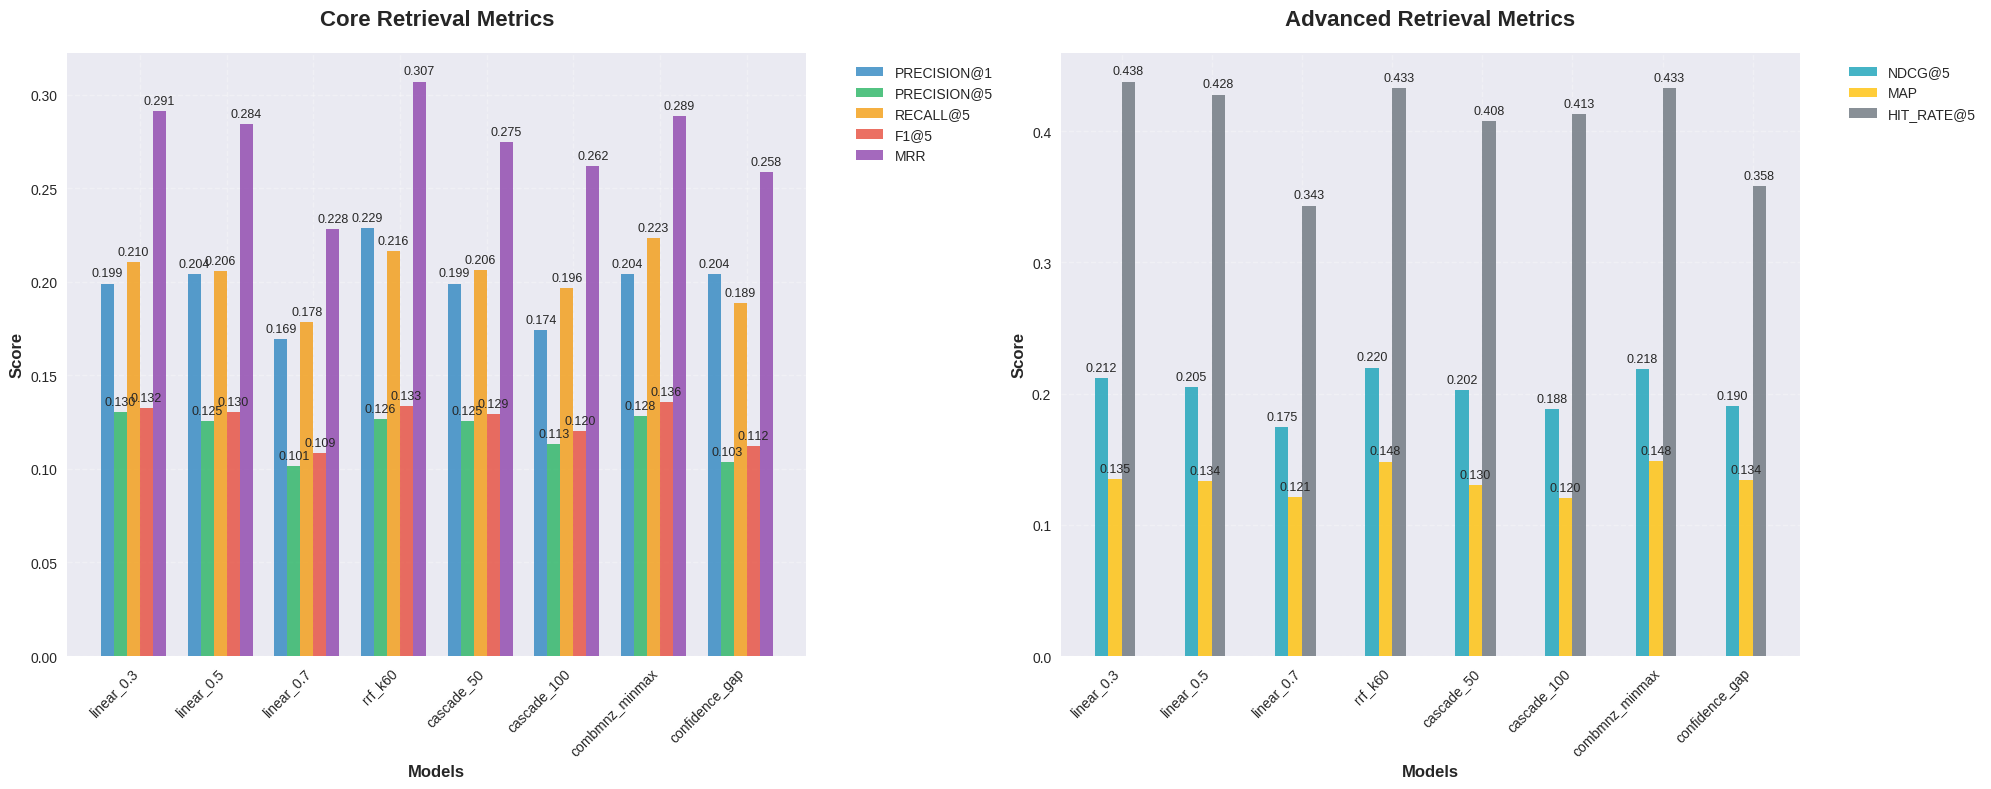

Performance plot saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/standard-hybrid/retrieval_performance.png

🔍 Creating comparison between baselines and hybrid strategies...


<Figure size 1400x1000 with 0 Axes>

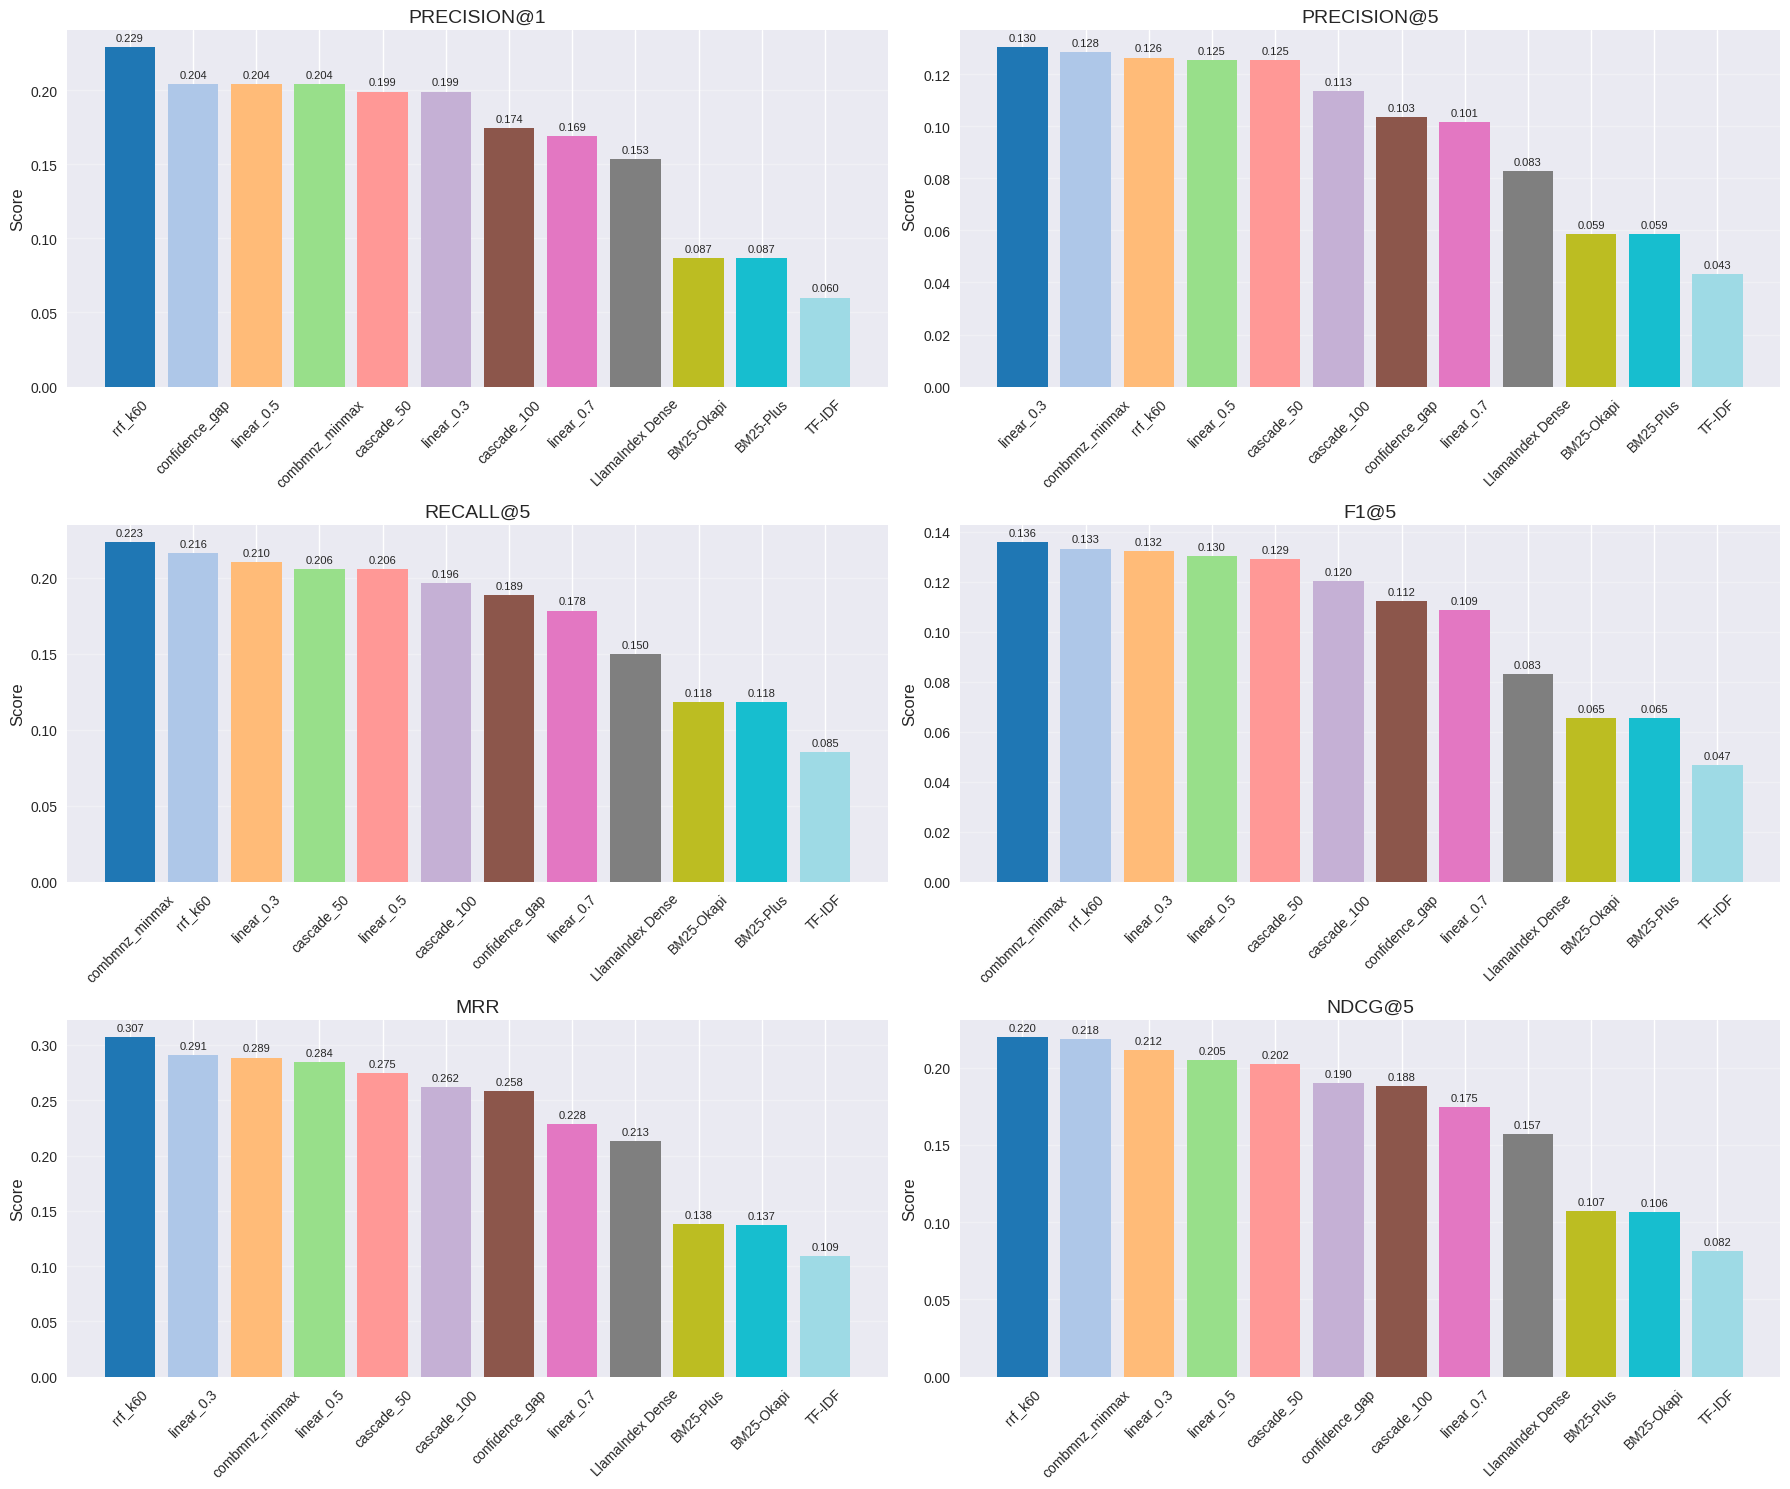

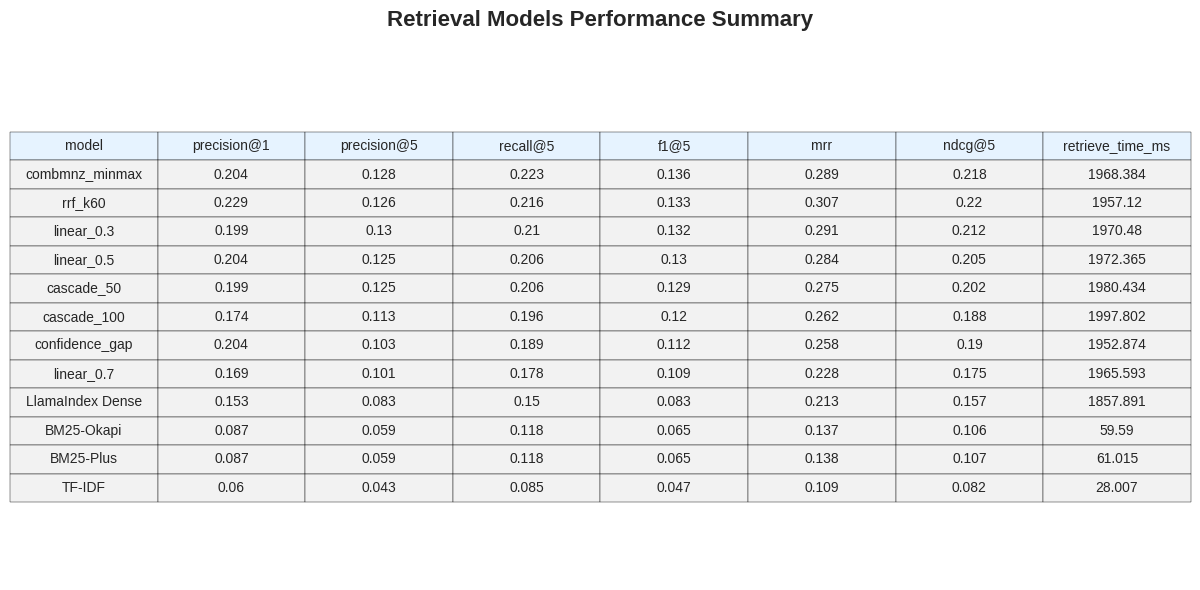

In [ ]:
# Create hybrid models
def create_and_evaluate_hybrid_models(sparse_models, dense_models, data, corpus_data, output_dir):
    """Create and evaluate hybrid retrieval models."""

    print("🔧 Creating hybrid retrieval models...")

    # Select best sparse model (BM25-Plus based on results)
    best_sparse = sparse_models['bm25_plus']
    best_dense = dense_models['dense']

    # Create hybrid models
    hybrid_models = {
        # Linear fusion with different alphas
        "linear_0.3": LinearScoreFusion(best_sparse, best_dense, alpha=0.3),  # More weight to dense
        "linear_0.5": LinearScoreFusion(best_sparse, best_dense, alpha=0.5),  # Equal weight
        "linear_0.7": LinearScoreFusion(best_sparse, best_dense, alpha=0.7),  # More weight to sparse

        # Rank-based fusion
        "rrf_k60": ReciprocalRankFusion(best_sparse, best_dense, k=60),

        # Two-stage retrieval
        "cascade_50": CascadeRetrieval(best_sparse, best_dense, corpus_data, first_stage_k=50),
        "cascade_100": CascadeRetrieval(best_sparse, best_dense, corpus_data, first_stage_k=100),

        # CombMNZ
        'combmnz_minmax': CombMNZ(
        best_sparse,
        best_dense,
        min_presence=1,
        normalization='min_max'  # Your original method
    ),

        'confidence_gap': ConfidenceAwareFusion(
        sparse_models['bm25_plus'],
        dense_models['dense'],
        base_alpha=0.5
        ),
    }

    # Evaluate all hybrid models
    print("\n📊 Evaluating hybrid strategies...")
    hybrid_results = evaluate_hybrid_strategies(
        hybrid_models,
        data['dev'],
        corpus_data,
        output_dir=output_dir
    )

    # Compare with baselines
    baseline_results = pd.read_csv("/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods/retrieval_evaluation.csv")

    print("\n🔍 Creating comparison between baselines and hybrid strategies...")
    all_results = compare_all_strategies(baseline_results, hybrid_results, output_dir=output_dir)

    return all_results, hybrid_models

# Run evaluation
results_dir = "/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/standard-hybrid"
all_results, hybrid_models = create_and_evaluate_hybrid_models(
    sparse_models,
    dense_models,
    data,
    corpus_data,
    output_dir=results_dir
)

#### Best Standard Hybrid Retrievals are :


* CombMNZ
* Reciprocal Rank Fusion (RRF)
* Linear_0.3
* Linear_0.5
* Cascade_50


# 8. Results Analysis

In [ ]:
# Complete model set for analysis
all_models = {
    # === BASELINE MODELS ===
    'BM25-Okapi': sparse_models['bm25_okapi'],
    'LlamaIndex Dense': dense_models['dense'],

    # === HYBRID MODELS ===
    'linear_0.3': LinearScoreFusion(sparse_models['bm25_plus'], dense_models['dense'], alpha=0.3),
    'linear_0.5': LinearScoreFusion(sparse_models['bm25_plus'], dense_models['dense'], alpha=0.5),
    'linear_0.7': LinearScoreFusion(sparse_models['bm25_plus'], dense_models['dense'], alpha=0.7),
    'rrf_k60': ReciprocalRankFusion(sparse_models['bm25_plus'], dense_models['dense'], k=60),
    'cascade_50': CascadeRetrieval(sparse_models['bm25_plus'], dense_models['dense'], corpus_data, first_stage_k=50),
    'combmnz_minmax': CombMNZ(sparse_models['bm25_plus'], dense_models['dense'], min_presence=1, normalization='min_max'),
    'confidence_gap': ConfidenceAwareFusion(sparse_models['bm25_plus'], dense_models['dense'], base_alpha=0.5,),
}

print(f"Total models for analysis: {len(all_models)}")

Total models for analysis: 9


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


hybrid_strategies = pd.read_csv("/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/standard-hybrid/hybrid_evaluation.csv")
baseline_methods = pd.read_csv("/content/drive/MyDrive/legal-rag-assistant/Notebooks/final-results/baseline-methods/retrieval_evaluation.csv")
# Your current results
# combine the baseline and the hybrid results in the hybrid_df_results
hybrid_df_results = pd.concat([baseline_methods, hybrid_strategies], ignore_index=True)


In [ ]:
def analyze_current_results():
    """Analyze current results to identify patterns and opportunities"""

    print("🔍 CURRENT RESULTS ANALYSIS")
    print("=" * 60)

    # Categorize methods
    hybrid_df_results['category'] = hybrid_df_results['model'].apply(lambda x:
        'Dense' if 'LlamaIndex' in x or 'Dense' in x else
        'Sparse' if x in ['BM25-Okapi', 'BM25-Plus', 'TF-IDF'] else
        'Hybrid'
    )

    # Performance analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Overall performance comparison
    metrics = ['precision@1', 'precision@5', 'recall@5', 'f1@5', 'mrr', 'ndcg@5']

    for i, metric in enumerate(metrics):
        ax = axes[i//3, i%3]
        bars = ax.bar(range(len(hybrid_df_results)), hybrid_df_results[metric],
                     color=['red' if cat=='Sparse' else 'blue' if cat=='Dense' else 'green'
                            for cat in hybrid_df_results['category']])
        ax.set_title(f'{metric.upper()} Comparison', fontweight='bold')
        ax.set_xticks(range(len(hybrid_df_results)))
        ax.set_xticklabels(hybrid_df_results['model'], rotation=45)
        ax.grid(axis='y', alpha=0.3)

        # Highlight best performer
        best_idx = hybrid_df_results[metric].idxmax()
        bars[best_idx].set_color('gold')
        ax.text(best_idx, hybrid_df_results[metric].iloc[best_idx] + 0.01,
                '★ BEST', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Performance vs Speed analysis
    plt.figure(figsize=(12, 8))

    # Create composite performance score
    hybrid_df_results['composite_score'] = (
        hybrid_df_results['precision@1'] * 0.2 +
        hybrid_df_results['recall@5'] * 0.3 +
        hybrid_df_results['f1@5'] * 0.25 +
        hybrid_df_results['mrr'] * 0.25
    )

    colors = {'Sparse': 'red', 'Dense': 'blue', 'Hybrid': 'green'}

    for category in hybrid_df_results['category'].unique():
        mask = hybrid_df_results['category'] == category
        plt.scatter(hybrid_df_results[mask]['retrieve_time_ms'],
                   hybrid_df_results[mask]['composite_score'],
                   c=colors[category], label=category, s=100, alpha=0.7)

        # Add model names
        for idx in hybrid_df_results[mask].index:
            plt.annotate(hybrid_df_results.loc[idx, 'model'],
                        (hybrid_df_results.loc[idx, 'retrieve_time_ms'],
                         hybrid_df_results.loc[idx, 'composite_score']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.xlabel('Retrieval Time (ms)')
    plt.ylabel('Composite Performance Score')
    plt.title('Performance vs Speed Trade-off Analysis', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return hybrid_df_results

🔍 CURRENT RESULTS ANALYSIS


<ipython-input-62-680325963>:36: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


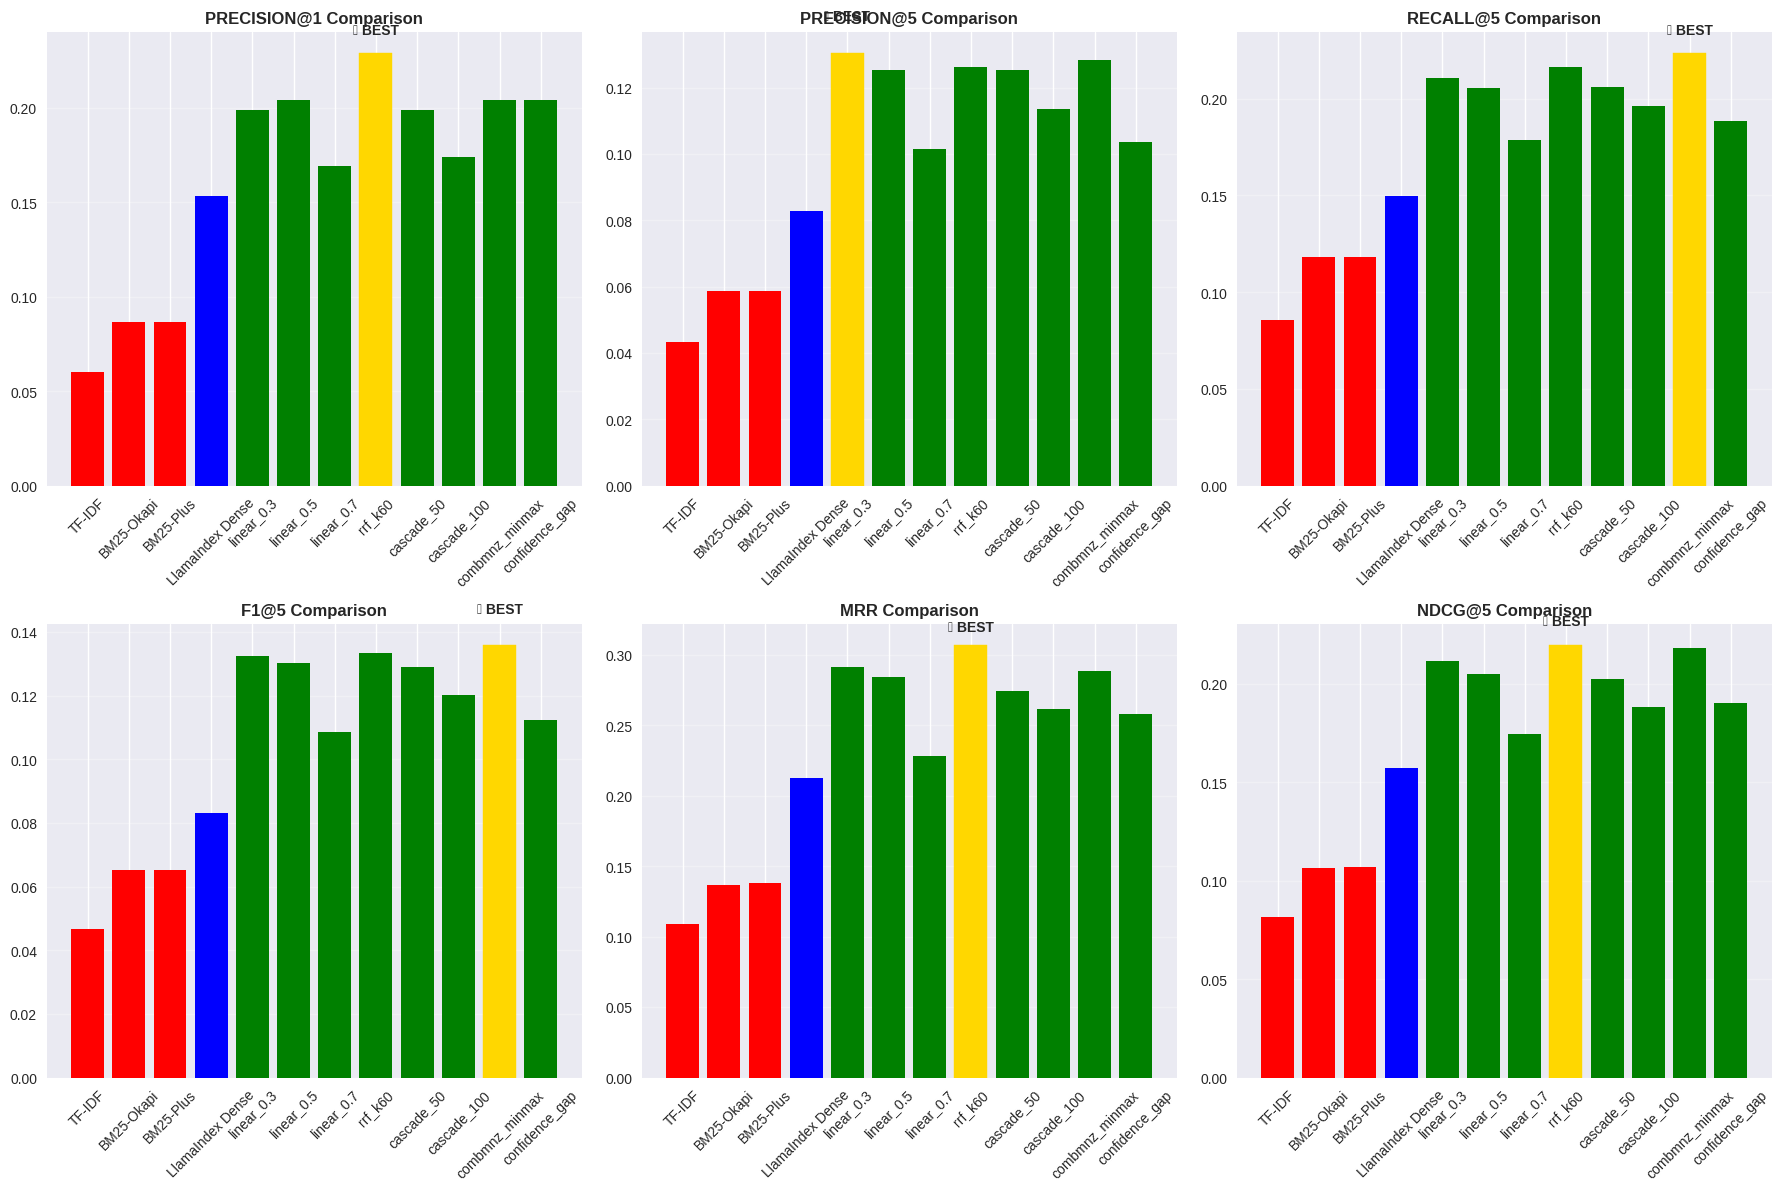

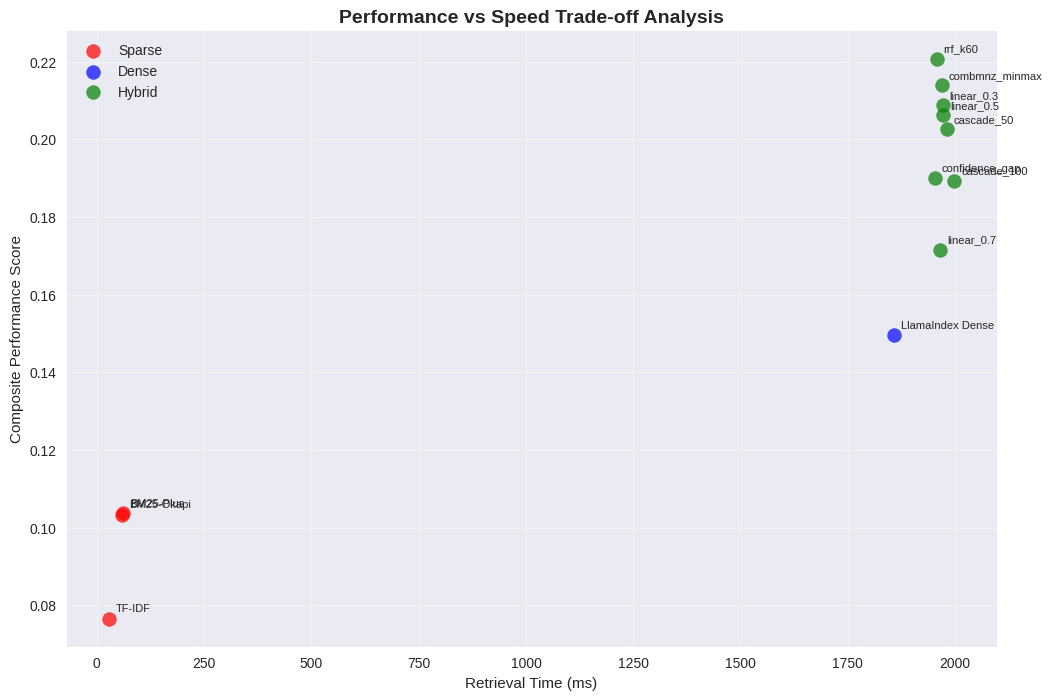

In [ ]:
# 1. Analyze current results
df_analyzed = analyze_current_results()

- **RRF (k=60):** Best overall with MRR=0.307 and P@1=0.229
- **CombMNZ (MinMax):** Strong second with balanced performance across metrics
- **Linear Fusion (α=0.3):** Consistently good, favoring dense retrieval slightly

## Key Findings

1. **Hybrid retrieval provides meaningful improvements** - RRF achieved 50% better P@1
   than the best baseline, proving the value of combining sparse and dense methods.

2. **Simple fusion often outperforms complex methods** - RRF and linear fusion beat
   more sophisticated approaches like confidence-aware fusion.

3. **Speed-accuracy trade-offs matter** - hybrid methods are 30x slower than sparse
   baselines, which may limit real-time applications.

4. **French legal retrieval is challenging** - even best methods achieve only 23% P@1,
   indicating room for improvement with domain-specific models.

## Limitations

- All models struggle with multi-article questions requiring complex reasoning
- Performance drops significantly for rare legal concepts